In [1]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

In [3]:
gd_results = pd.read_table('/home/comp/cszrwang/results/Deconvolution/results/STARmap/combined_spot_clusters.txt', sep = '\t', header = 0, index_col = 0)
gd_results.columns = ['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5', 'Excitatory L6', 'HPC', 'Micro', 'Npy'
                     , 'Olig', 'Other', 'Inhibitory Pvalb', 'Smc', 'Inhibitory Sst', 'Inhibitory Vip']
gd_results = (gd_results.T/gd_results.sum(axis=1)).T

gd_results = gd_results.drop(columns=['Other','Npy', 'HPC'])
gd_results = gd_results.loc[:,np.unique(gd_results.columns)]

gd_results = gd_results.fillna(0)

gd_loc = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/combined_Locations.txt',sep='\t')

In [5]:
def plot_starmap_celltype(celltype=None,celltype_ind=None,save=None,return_fig=False):
    if celltype is not None:
        celltype_ind = np.where(celltype == tangram_results.columns)[0]
    elif celltype_ind is not None:
        celltype = tangram_results.columns[celltype_ind]
    else:
        raise Error('error')
    print(celltype)
    c_ind = celltype_ind
    fig,axes = plt.subplots(ncols=1,nrows=2,figsize=(5,16.0))
    # fig.tight_layout()
    axes[0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results.iloc[:,c_ind],s=1000,marker='s')
    axes[0].scatter(x=5,y=18,c=0,s=1000,marker='s')
    axes[0].set_xlim(-0.5,9.5)
    axes[0].set_ylim(-0.5,18.5)
    axes[0].axis('off')
    axes[0].set_title('Ground Truth')
    
    axes[1].scatter(x=gd_loc['x'],y=gd_loc['y'],c=harmo_results.iloc[:,c_ind],s=1000,marker='s')
    axes[1].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[1].set_xlim(-0.5,9.5)
    axes[1].set_ylim(-0.5,18.5)
    axes[1].axis('off')
    axes[1].set_title('Harmo')
    if save is not None:
        plt.savefig(save,bbox_inches='tight',dpi=300)
    if not return_fig:
        plt.show()
    else:
        plt.close()
        return fig

In [9]:
def ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim

def rmse(x1,x2):
    return mean_squared_error(x1,x2,squared=False)
def mae(x1,x2):
    return np.mean(np.abs(x1-x2))

from collections.abc import Iterable
def compare_results(gd,result_list,metric='pcc',columns=None,axis=1):
    if metric=='pcc':
        func = pearsonr
        r_ind = 0
    if metric=='mae':
        func = mae
        r_ind = None
    if metric=='jsd':
        func = jensenshannon
        r_ind = None
    if metric=='rmse':
        func = rmse
        r_ind = None
    if metric=='ssim':
        func = ssim
        r_ind = None
    if isinstance(result_list, pd.DataFrame):
        c_list = []
        if axis == 1:
            print('axis: ',1)
            for i,c in enumerate(gd.columns):
                r = func(gd.iloc[:,i].values, np.clip(result_list.iloc[:,i],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        else:
            print('axis: ',0)
            for i,c in enumerate(gd.index):
                r = func(gd.iloc[i,:].values, np.clip(result_list.iloc[i,:],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        df = pd.DataFrame(c_list,index=gd.columns,columns=columns)
    else:
        df_list = []
        for res in result_list:
            c_list = []
            if axis == 1:
                for i,c in enumerate(gd.columns):
                    r = func(gd.iloc[:,i].values, np.clip(res.iloc[:,i],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.columns)
            else:
                for i,c in enumerate(gd.index):
                    r = func(gd.iloc[i,:].values, np.clip(res.iloc[i,:],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.index)
            df_list.append(df_tmp)
        df = pd.concat(df_list,axis=1)
        df.columns = columns
    return df

In [10]:
def draw_pie(dist, xpos, ypos, size, colors, ax):

    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    i = 0
    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2, num=100)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])
        ax.scatter([xpos], [ypos], marker=xy, s=size, c=colors[i], edgecolors='none')
        i += 1

    return ax

def plot_frac_results(predict, cell_type_list, coordinates, file_name=None, point_size=1000, size_coefficient=0.0009, if_show=True, color_dict=None):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    labels = cell_type_list
    if color_dict != None:
        colors = []
        for i in cell_type_list:
            colors.append(color_dict[i])
    else:
        if len(labels) <= 10:
            colors = plt.rcParams["axes.prop_cycle"].by_key()['color'][:len(labels)]
        else:
            import matplotlib
            color = plt.get_cmap('rainbow', len(labels))
            colors = []
            for x in color([range(len(labels))][0]):
                colors.append(matplotlib.colors.to_hex(x, keep_alpha=False))
    
    str_len = 0
    for item in cell_type_list:
        str_len = max(str_len, len(item))
    extend_region = str_len/15+1
    
    
    fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+extend_region, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
    
    for i in tqdm(range(predict.shape[0]), desc="Plotting pie plots:"):
        ax = draw_pie(predict[i], coordinates['coor_X'].values[i], coordinates['coor_Y'].values[i], 
                                              size=point_size, ax=ax, colors=colors)
        
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')  # Set edge line color of all spines to grey
    
    
    patches = [mpatches.Patch(color=colors[i], label="{:s}".format(labels[i]) ) for i in range(len(colors))]
    fontsize = max(predict.shape[0]/100, 10)
    fontsize = min(fontsize, 30)
    ax.legend(handles=patches, fontsize=fontsize, bbox_to_anchor=(1, 1), loc="upper left")
    plt.axis("equal")
#     plt.edgecolors("lightgrey")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name, 
                    dpi=300, 
#                     bbox_inches='tight'
                   )
    if if_show == True:
        plt.show()
    plt.close('all')
    
    
    
def plot_scatter_by_type(predict, cell_type_list, coordinates, point_size=400, size_coefficient=0.0009, file_path=None, if_show=True):
    
    coordinates.columns = ['coor_X', 'coor_Y']
    
    for i in tqdm(range(len(cell_type_list)), desc="Plotting cell type scatter plot:"):
        
        fig, ax = plt.subplots(figsize=(len(coordinates['coor_X'].unique())*point_size*size_coefficient+1, len(coordinates['coor_Y'].unique())*point_size*size_coefficient))
        cm = plt.cm.get_cmap('Reds')
        ax = plt.scatter(coordinates['coor_X'], coordinates['coor_Y'], s=point_size, vmin=0, vmax=1, c=predict[:, i], cmap=cm)

        cbar = plt.colorbar(ax, fraction=0.05)
        labelsize = max(predict.shape[0]/100, 10)
        labelsize = min(labelsize, 30)
        cbar.ax.tick_params(labelsize=labelsize)
        plt.axis("equal")
        plt.xticks([])
        plt.yticks([])
        plt.xlim(coordinates['coor_X'].min()-0.5, coordinates['coor_X'].max()+0.5)
        plt.ylim(coordinates['coor_Y'].min()-0.5, coordinates['coor_Y'].max()+0.5)
        plt.tight_layout()
        if file_path != None:
            name = cell_type_list[i].replace('/', '_')
            plt.savefig(file_path+'/{}.jpg'.format(name), dpi=300, bbox_inches='tight')
        if if_show == True:
            plt.show()
        plt.close('all')

In [11]:
color_dict = {'Astro': '#FCCDE5', 'Endo': '#D9D9D9', 'Excitatory L2/3': '#FFCC00', 'Excitatory L4': '#FFFF66',
             'Excitatory L5': '#99CC00', 'Excitatory L6': '#CCFFFF', 'Inhibitory Pvalb': '#666699', 'Inhibitory Sst': '#666633', 'Inhibitory Vip': '#993366',
             'Micro': '#333333', 'Olig': '#F0027F', 'Smc': '#666666', 'Other': '#BF5B17'}

In [12]:
tangram_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/Tangram/Tangram_result.csv',index_col=0)
tangram_results = tangram_results.loc[:,np.unique(tangram_results.columns)]
tangram_results['Other'] = tangram_results['Other'] + tangram_results['Inhibitory Other'] + tangram_results['Neuron Other']
tangram_results = tangram_results.drop(columns=['Neuron Other','Inhibitory Other'])

In [13]:
output_dir = '/home/comp/cszrwang/results/Deconvolution/results/STARmap/Figures'
cell_type_list = tangram_results.columns.to_list()
coordinates = gd_loc[['x', 'y']]

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

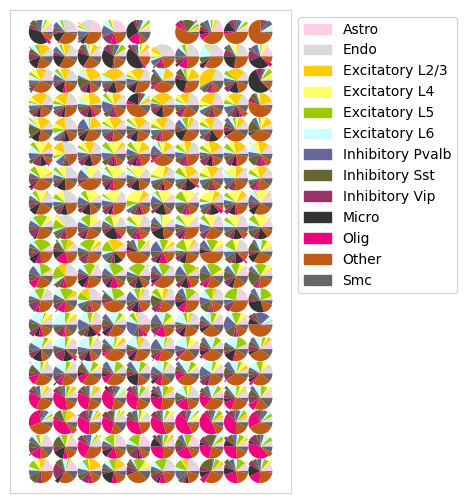

In [14]:
plot_frac_results(np.array(tangram_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/tangram_results_pie_plot.jpg', color_dict=color_dict)

In [15]:
cell2loc_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/Cell2location/Cell2location_result.csv',index_col=0)
cell2loc_results.index = np.arange(len(cell2loc_results))
cell2loc_results = (cell2loc_results.T/cell2loc_results.sum(axis=1)).T
# cell2loc_results.columns = [c.split('q05cell_abundance_w_sf_')[1] for c in cell2loc_results.columns]
cell2loc_results['Other'] = cell2loc_results['Other'] + cell2loc_results['Inhibitory Other'] + cell2loc_results['Neuron Other']
cell2loc_results = cell2loc_results.drop(columns=['Neuron Other','Inhibitory Other'])
cell2loc_results = cell2loc_results.loc[:,np.unique(cell2loc_results.columns)]

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

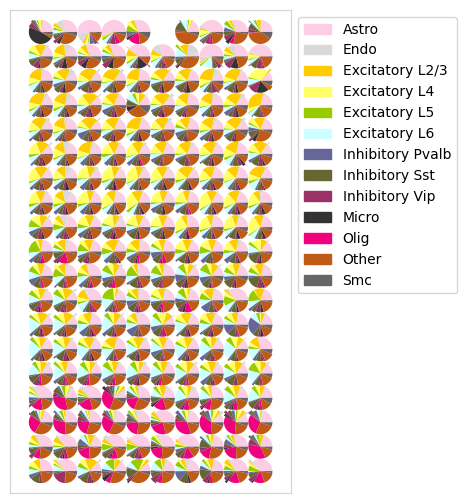

In [16]:
plot_frac_results(np.array(cell2loc_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/cell2loc_results_pie_plot.jpg', color_dict=color_dict)

In [17]:
RCTD_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/RCTD/RCTD_output.csv',index_col=0)
RCTD_results.index = np.arange(len(RCTD_results))
RCTD_results = RCTD_results.loc[:,np.unique(RCTD_results.columns)]
RCTD_results['Other'] = RCTD_results['Other'] + RCTD_results['Inhibitory Other'] + RCTD_results['Neuron Other']
RCTD_results = RCTD_results.drop(columns=['Neuron Other','Inhibitory Other'])
RCTD_results.columns = tangram_results.columns

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

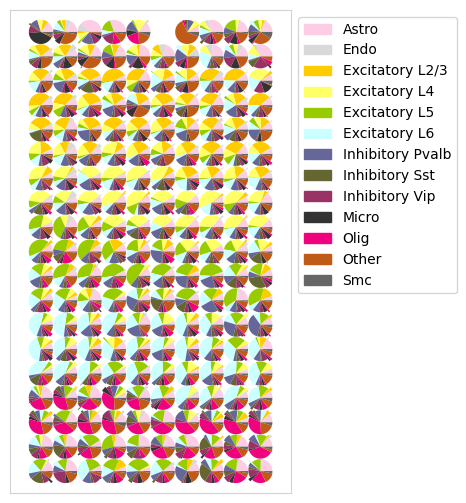

In [18]:
plot_frac_results(np.array(RCTD_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/RCTD_results_pie_plot.jpg', color_dict=color_dict)

In [19]:
spatialdwls_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/SpatialDWLS/SpatialDWLS_result.csv',index_col=0)
spatialdwls_results.index = np.arange(len(spatialdwls_results))
spatialdwls_results = spatialdwls_results.iloc[:,1:]
spatialdwls_results = spatialdwls_results.loc[:,np.unique(spatialdwls_results.columns)]
spatialdwls_results['Other'] = spatialdwls_results['Other'] + spatialdwls_results['Inhibitory Other'] + spatialdwls_results['Neuron Other']
spatialdwls_results = spatialdwls_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

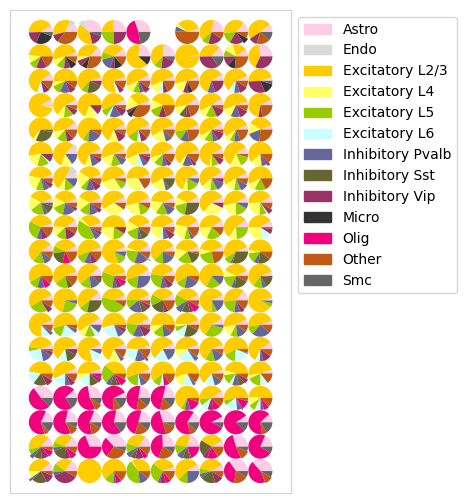

In [20]:
plot_frac_results(np.array(spatialdwls_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/spatialdwls_results_pie_plot.jpg', color_dict=color_dict)

In [21]:
stereo_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/Stereoscope/Stereoscope_result.csv',index_col=0)
stereo_results.index = np.arange(len(stereo_results))
stereo_results = stereo_results.loc[:,np.unique(stereo_results.columns)]
stereo_results['Other'] = stereo_results['Other'] + stereo_results['Inhibitory Other'] + stereo_results['Neuron Other']
stereo_results = stereo_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

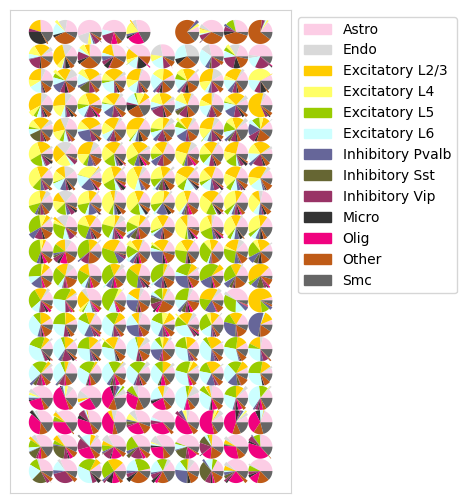

In [22]:
plot_frac_results(np.array(stereo_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/stereo_results_pie_plot.jpg', color_dict=color_dict)

In [23]:
spotlight_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/Spotlight/SPOTlight_output.csv',index_col=0)
spotlight_results.index = np.arange(len(spotlight_results))
spotlight_results = spotlight_results.loc[:,np.unique(spotlight_results.columns)]
spotlight_results = spotlight_results.fillna(0)
spotlight_results['Other'] = spotlight_results['Other'] + spotlight_results['Inhibitory Other'] + spotlight_results['Neuron Other']
spotlight_results = spotlight_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

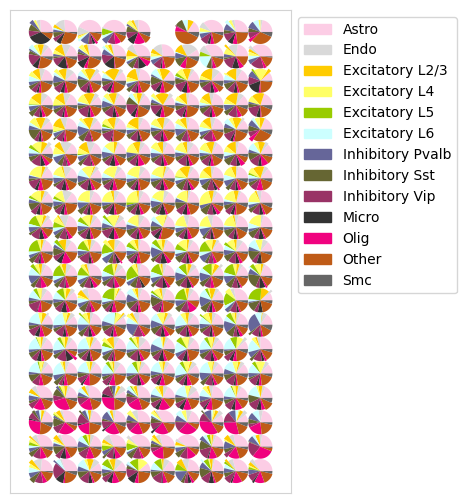

In [24]:
plot_frac_results(np.array(spotlight_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/spotlight_results_pie_plot.jpg', color_dict=color_dict)

In [25]:
red_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/Redeconve/Redeconve.csv',index_col=0)
red_results.index = np.arange(len(red_results))
red_results = red_results.loc[:,np.unique(red_results.columns)]
red_results['Other'] = red_results['Other'] + red_results['Inhibitory Other'] + red_results['Neuron Other']
red_results = red_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

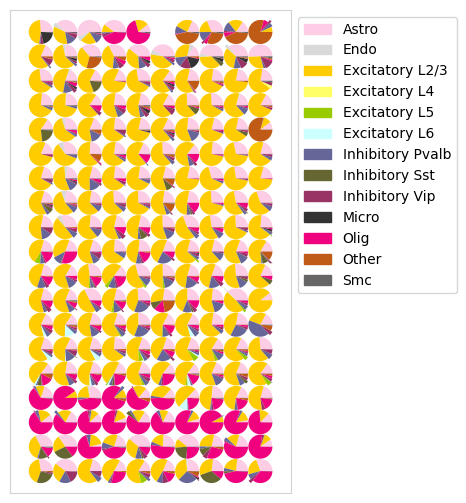

In [26]:
plot_frac_results(np.array(red_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/red_results_pie_plot.jpg', color_dict=color_dict)

In [27]:
dstg_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/DSTG/DSTG_output.csv',index_col=0)
dstg_results = (dstg_results.T/dstg_results.sum(axis=1)).T
dstg_results = dstg_results.loc[:,np.unique(dstg_results.columns)]
dstg_results['Other'] = dstg_results['Other'] + dstg_results['Inhibitory Other'] + dstg_results['Neuron Other']
dstg_results = dstg_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

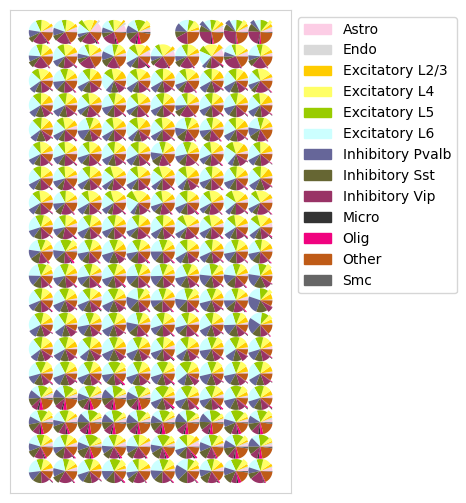

In [28]:
plot_frac_results(np.array(dstg_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/dstg_results_pie_plot.jpg', color_dict=color_dict)

In [29]:
card_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/CARD/CARD_output.csv')
card_results.index = np.arange(len(card_results))
card_results = card_results.loc[:,np.unique(card_results.columns)]
card_results['Other'] = card_results['Other'] + card_results['Inhibitory Other'] + card_results['Neuron Other']
card_results = card_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

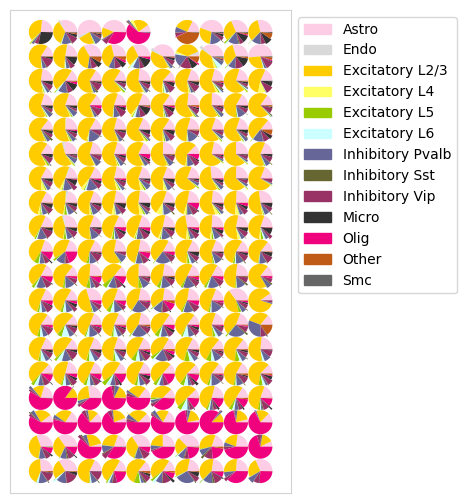

In [30]:
plot_frac_results(np.array(card_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/card_results_pie_plot.jpg', color_dict=color_dict)

In [31]:
stdgcn_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/StdGCN/predict_result.csv',index_col=0)
stdgcn_results.index = np.arange(len(stdgcn_results))
stdgcn_results = stdgcn_results.loc[:,np.unique(stdgcn_results.columns)]
stdgcn_results['Other'] = stdgcn_results['Other'] + stdgcn_results['Inhibitory Other'] + stdgcn_results['Neuron Other']
stdgcn_results = stdgcn_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

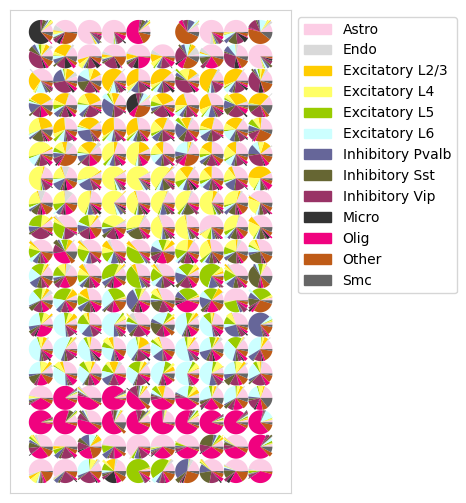

In [32]:
plot_frac_results(np.array(stdgcn_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/stdgcn_results_pie_plot.jpg', color_dict=color_dict)

In [33]:
spacel_results = pd.read_csv('/home/comp/cszrwang/results/Deconvolution/results/STARmap/SPACEL/SPACEL_result.csv',index_col=0)
spacel_results.index = np.arange(len(spacel_results))
spacel_results = spacel_results.loc[:,np.unique(spacel_results.columns)]
spacel_results['Other'] = spacel_results['Other'] + spacel_results['Inhibitory Other'] + spacel_results['Neuron Other']
spacel_results = spacel_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

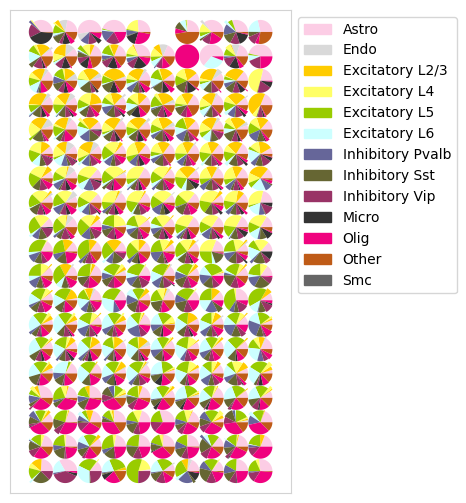

In [34]:
plot_frac_results(np.array(spacel_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/spacel_results_pie_plot.jpg', color_dict=color_dict)

In [36]:
harmo_results = pd.read_csv("/home/comp/cszrwang/project/GMGAT4Deconv/figures/mean_out_starmap_seed_1_20_seed1.model.csv")
harmo_results = harmo_results.loc[:,np.unique(harmo_results.columns)].fillna(0)
harmo_results['Other'] = harmo_results['Other'] + harmo_results['Inhibitory Other'] + harmo_results['Neuron Other']
harmo_results = harmo_results.drop(columns=['Neuron Other','Inhibitory Other'])

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

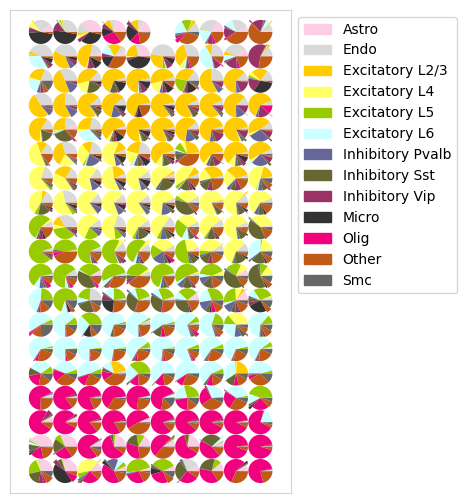

In [37]:
plot_frac_results(np.array(harmo_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/gmgcn_results_pie_plot.jpg', color_dict=color_dict)

In [39]:
gd_results = pd.read_table('/home/comp/cszrwang/results/Deconvolution/results/STARmap/combined_spot_clusters.txt', sep = '\t', header = 0, index_col = 0)
gd_results.columns = ['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5', 'Excitatory L6', 'HPC', 'Micro', 'Npy'
                     , 'Olig', 'Other', 'Inhibitory Pvalb', 'Smc', 'Inhibitory Sst', 'Inhibitory Vip']
gd_results = (gd_results.T/gd_results.sum(axis=1)).T

gd_results['Other'] = gd_results['Other'] + gd_results['Npy'] + gd_results['HPC']
gd_results = gd_results.drop(columns=['Npy', 'HPC'])
gd_results = gd_results.loc[:,np.unique(gd_results.columns)]

gd_results = gd_results.fillna(0)

Plotting pie plots::   0%|          | 0/189 [00:00<?, ?it/s]

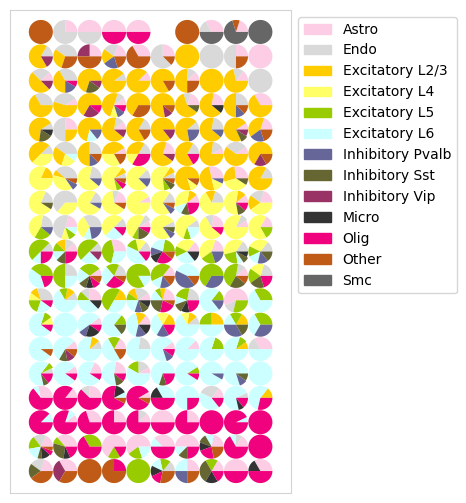

In [40]:
plot_frac_results(np.array(gd_results), cell_type_list, coordinates, point_size=300, size_coefficient=0.0009
                  , file_name=output_dir+'/gd_results_pie_plot.jpg', color_dict=color_dict)

In [41]:
tangram_results = tangram_results.drop(columns=['Other'])
# seurat_results = seurat_results.drop(columns=['Other'])
red_results = red_results.drop(columns=['Other'])
RCTD_results = RCTD_results.drop(columns=['Other'])
cell2loc_results = cell2loc_results.drop(columns=['Other'])
stereo_results = stereo_results.drop(columns=['Other'])
spotlight_results = spotlight_results.drop(columns=['Other'])
spatialdwls_results = spatialdwls_results.drop(columns=['Other'])
dstg_results = dstg_results.drop(columns=['Other'])
spacel_results = spacel_results.drop(columns=['Other'])
stdgcn_results = stdgcn_results.drop(columns=['Other'])
card_results = card_results.drop(columns=['Other'])

In [42]:
gd_results = gd_results.drop(columns=['Other'])
harmo_results = harmo_results.drop(columns=['Other'])

In [43]:
column = ['HarmoDecon', 'RCTD', 'Redeconve', 'StdGCN','CARD', 'Cell2location', 'Tangram', 'Stereoscope', 'SPACEL', 'SpatialDWLS', 'SPOTlight', 'DSTG']
results_list = [harmo_results, RCTD_results, red_results, stdgcn_results, card_results, cell2loc_results,
               tangram_results, stereo_results, spacel_results, spatialdwls_results, spotlight_results, dstg_results]
# for i in results_list:
#     print(len(i.columns))
starmap_spots_pcc = compare_results(
    gd_results,
    results_list,
    columns = column,
    axis=0,
    metric='pcc'
)

starmap_spots_ssim = compare_results(
    gd_results,
    results_list,
    columns = column,
    axis=0,
    metric='ssim'
)

starmap_spots_rmse = compare_results(
    gd_results,
    results_list,
    columns = column,
    axis=0,
    metric='rmse'
)

starmap_spots_jsd = compare_results(
    gd_results,
    results_list,
    columns = column,
    axis=0,
    metric='jsd'
)

/home/comp/cszrwang/anaconda3/envs/dl_transformer/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/tmp/ipykernel_406680/1328010868.py:2: RuntimeWarning: invalid value encountered in divide
  im1, im2 = im1/im1.max(), im2/im2.max()
/home/comp/cszrwang/anaconda3/envs/dl_transformer/lib/python3.9/site-packages/scipy/spatial/distance.py:1287: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


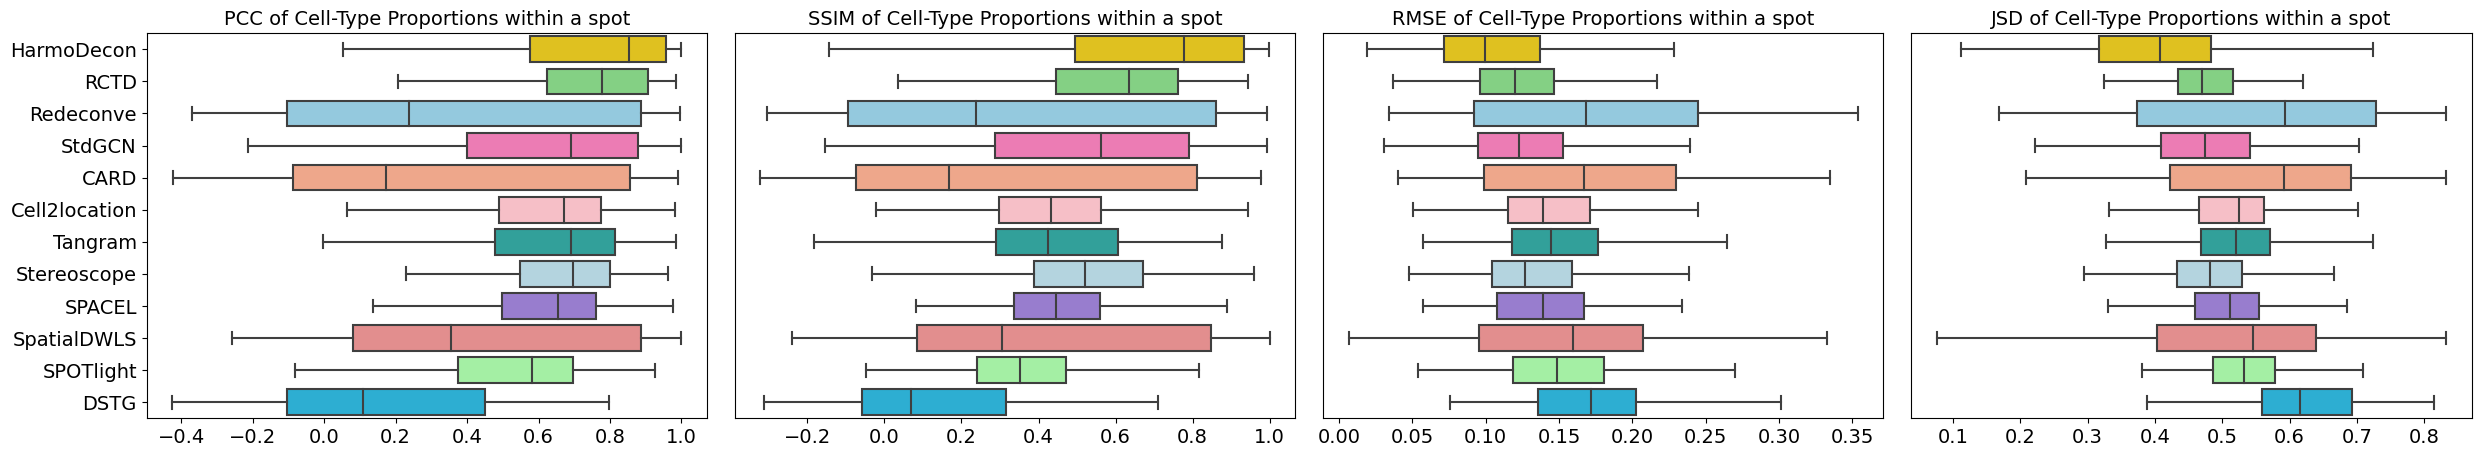

In [45]:
fig,axes = plt.subplots(ncols=4,nrows=1,figsize=(30,5))
plt.subplots_adjust(wspace=0.05, hspace=0.2)
order = column
# colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",  "#A2CBCF", "#988DC3", "#79c06e",'#00CED1',"#BBA8D1", "#9dff46", "#E6AB02", "#FCCDE5", "#CCFFFF", "#dddddd", "#cccccc", "#aaaaaa"]
colors = ['#FFD700', '#77DD77', '#87CEEB', '#FF69B4', '#FFA07A', '#FFB6C1', '#20B2AA', '#ADD8E6', '#9370DB', '#F08080', '#98FB98', '#11BEEE']
# order_plt = ['mse_recon_js_ce','mse_recon_js', 'mse_recon_ce', 'mse_js_ce','mse','mse_ce','mse_recon']
sns.boxplot(data=starmap_spots_pcc,order=order,palette=colors,ax=axes[0],orient='h', showfliers = False)
axes[0].set_title('PCC of Cell-Type Proportions within a spot', size = 14)
sns.boxplot(data=starmap_spots_ssim,order=order,palette=colors,ax=axes[1],orient='h', showfliers = False)
axes[1].set_title('SSIM of Cell-Type Proportions within a spot', size = 14)
axes[1].set_yticklabels([])
axes[1].yaxis.set_visible(False)
sns.boxplot(data=starmap_spots_rmse,order=order,palette=colors,ax=axes[2],orient='h', showfliers = False)
axes[2].set_title('RMSE of Cell-Type Proportions within a spot', size = 14)
axes[2].set_yticklabels([])
axes[2].yaxis.set_visible(False)
sns.boxplot(data=starmap_spots_jsd,order=order,palette=colors,ax=axes[3],orient='h', showfliers = False)
axes[3].set_title('JSD of Cell-Type Proportions within a spot', size = 14)
axes[3].set_yticklabels([])
axes[3].yaxis.set_visible(False)
for i, ax in enumerate(axes.flat):
    if i in [0,2]:
        ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
plt.savefig(output_dir+'/criterion_box_plot.jpg',dpi=300,bbox_inches='tight')
plt.show()

In [46]:
# print(starmap_spots_pcc.mean().sort_values())
pcc_rank = starmap_spots_pcc.apply(lambda x: x.rank(), axis=1)
ssim_rank = starmap_spots_ssim.apply(lambda x: x.rank(), axis=1)
jsd_rank = starmap_spots_jsd.apply(lambda x: x.rank(ascending=False), axis=1)
rmse_rank = starmap_spots_rmse.apply(lambda x: x.rank(ascending=False), axis=1)
# pcc_rank = starmap_spots_pcc.sort_values(by='default_column').rank()
rank_sum = pd.DataFrame((pcc_rank + ssim_rank + jsd_rank + rmse_rank) / 48)
print(rank_sum)

     HarmoDecon      RCTD  Redeconve    StdGCN      CARD  Cell2location  \
0      0.895833  0.375000   0.416667  0.562500  0.145833       0.750000   
1      0.750000  0.958333   0.208333  0.416667  0.125000       0.729167   
2      0.916667  0.583333   0.791667  1.000000  0.625000       0.291667   
3      0.729167  0.520833   0.979167  0.625000  0.812500       0.270833   
4      0.937500  0.979167   0.083333  0.812500  0.166667       0.458333   
..          ...       ...        ...       ...       ...            ...   
184    0.812500  0.583333   0.708333  0.166667  1.000000       0.687500   
185    0.375000  0.479167   0.895833  0.291667  0.833333       0.666667   
186    1.000000  0.437500   0.395833  0.895833  0.395833       0.416667   
187    0.104167  0.416667   0.708333  1.000000  0.812500       0.895833   
188    0.229167  0.750000   0.312500  0.916667  0.312500       0.791667   

      Tangram  Stereoscope    SPACEL  SpatialDWLS  SPOTlight      DSTG  
0    0.645833     0.770833

/tmp/ipykernel_406680/3014842231.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=rank_sum,palette=colors, capsize=0.1, ci=95, errwidth=1.5, orient='h', edgecolor='black', linewidth=2)
/home/comp/cszrwang/anaconda3/envs/dl_transformer/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/comp/cszrwang/anaconda3/envs/dl_transformer/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/comp/cszrwang/anaconda3/envs/dl_transformer/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and 

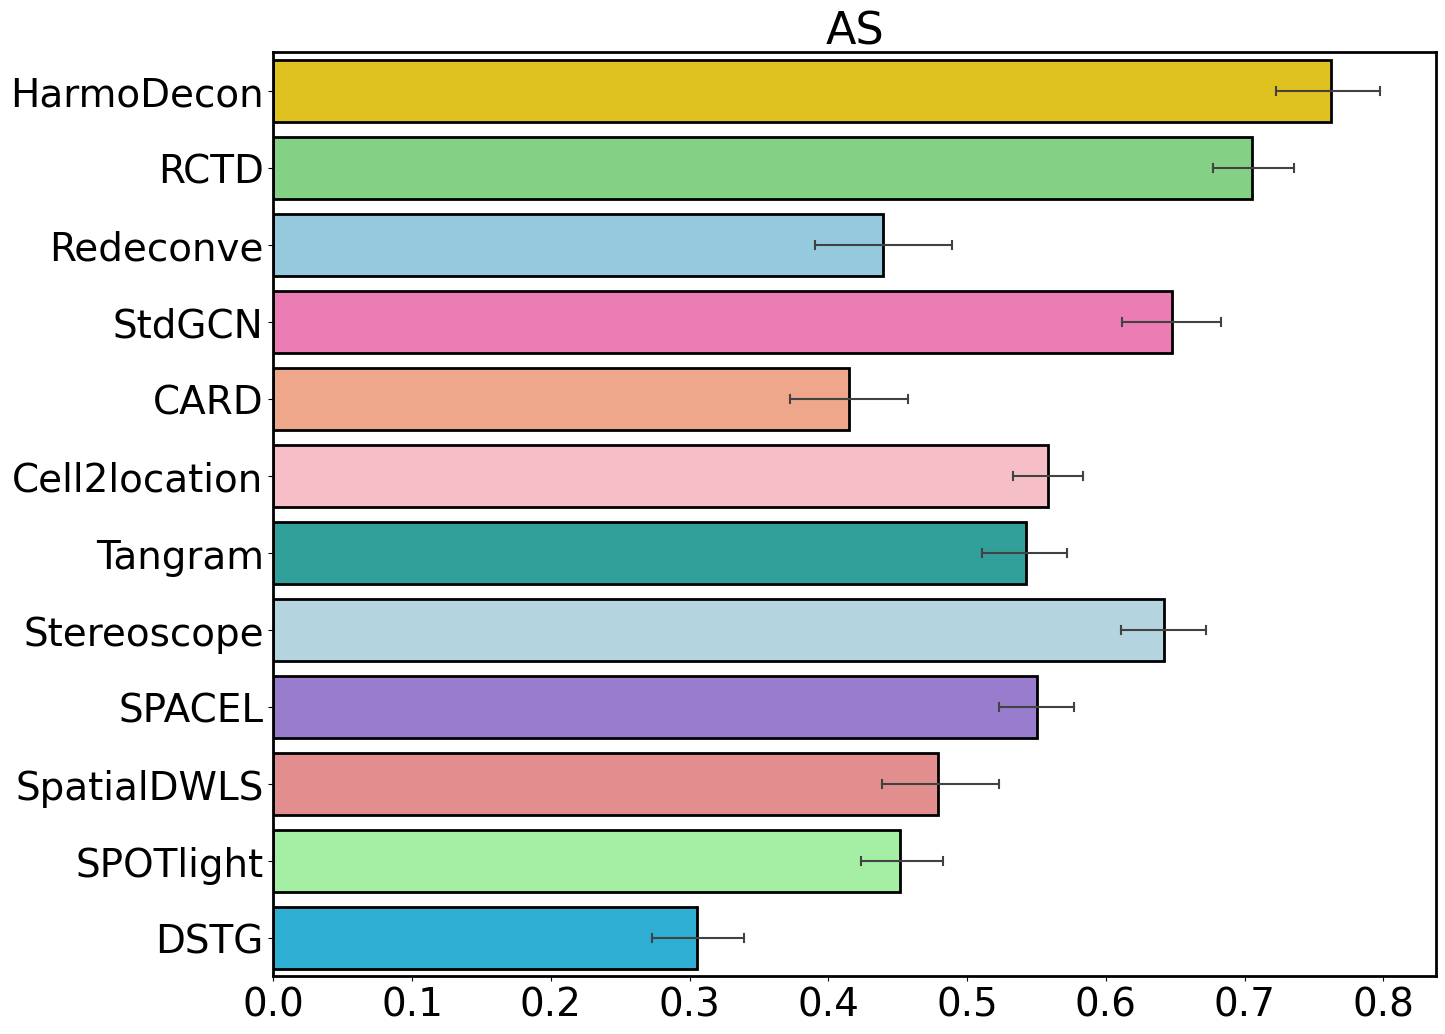

In [49]:
fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(15,12))
colors = ['#FFD700', '#77DD77', '#87CEEB', '#FF69B4', '#FFA07A', '#FFB6C1', '#20B2AA', '#ADD8E6', '#9370DB', '#F08080', '#98FB98', '#11BEEE']
# order_plt = ['mse_recon_js_ce','mse_recon_js', 'mse_recon_ce', 'mse_js_ce','mse','mse_ce','mse_recon']
sns.barplot(data=rank_sum,palette=colors, capsize=0.1, ci=95, errwidth=1.5, orient='h', edgecolor='black', linewidth=2)
axes.set_title('AS', fontsize=32)

# Get the current axes
ax = plt.gca()

# Customize the border of the plot box
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# ax.set_yticklabels(columns)
# ax.yaxis.set_visible(False)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig(output_dir+'/box_AS.jpg',dpi=300,bbox_inches='tight')
plt.show()

In [50]:
import math

In [51]:
import math
def plot_entropy(out_dir, column, results_list):
    entropy_list = []
    column.append("Ground Truth")
    for name, result in zip(column, results_list):
        entropy = result.map(lambda x: -x * math.log2(x+0.000001)).mean(axis = 1)
        entropy_list.append(entropy)
    entropy = gd_results.map(lambda x: -x * math.log2(x+0.000001)).mean(axis = 1)
    entropy_list.append(entropy)
    entropies = pd.DataFrame(entropy_list).T
    entropies.columns = column
    fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(8,6))
    order = ['Ground Truth', 'HarmoDecon', 'RCTD', 'StdGCN', 'SPOTlight', 'Cell2location', 'Tangram', 'Stereoscope', 'SPACEL', 'SpatialDWLS', 'Redeconve','CARD', 'DSTG']
    colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",  "#A2CBCF", "#988DC3", "#79c06e",'#00CED1',"#BBA8D1", "#9dff46", "#E6AB02", "#FCCDE5", "#CCFFFF", "#dddddd", "#cccccc", "#aaaaaa"]
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",]
    # order_plt = ['mse_recon_js_ce','mse_recon_js', 'mse_recon_ce', 'mse_js_ce','mse','mse_ce','mse_recon']
    sns.boxplot(data=entropies,order=order,palette=colors,ax=axes,orient='h', showfliers = False,showmeans=True)
#     axes.set_title('Information Entropy of Cell-Type Proportion per Spot')
    plt.title('Information Entropy of Cell-Type Proportion per Spot',fontsize=16)
    plt.savefig(out_dir+'/entropy_box_plot.jpg',dpi=300,bbox_inches='tight')
    plt.show()

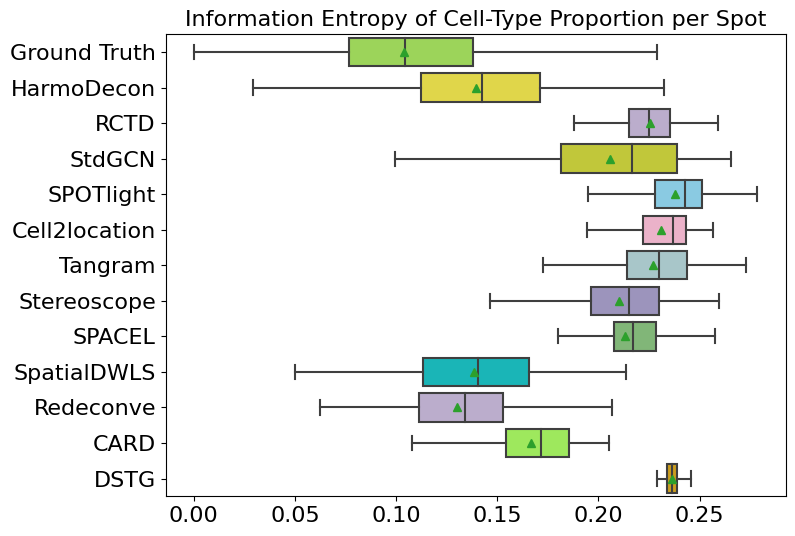

In [52]:
out_dir_entropy = output_dir + "/linear"
column = ['HarmoDecon', 'RCTD', 'Redeconve', 'StdGCN','CARD', 'Cell2location', 'Tangram', 'Stereoscope', 'SPACEL', 'SpatialDWLS', 'SPOTlight', 'DSTG']
results_list = [harmo_results, RCTD_results, red_results, stdgcn_results, card_results, cell2loc_results,
               tangram_results, stereo_results, spacel_results, spatialdwls_results, spotlight_results, dstg_results]
plot_entropy(out_dir_entropy, column, results_list)

In [53]:
from scipy.stats import linregress

In [56]:
def plot_linear(out_dir, column, results_list, legend=True, yticks=True):
    p_list = []
    r_list = []
    mse_list = []
    gd_results_cells = pd.read_table('/home/comp/cszrwang/project/Geneformer_test/STARmap/toy/Spatial_annotate.txt', sep = '\t', header = 0, index_col = 0)
    cells = gd_results_cells['celltype'].value_counts()
    cells = cells.drop(['Other','Npy', 'HPC'])
    cells['Excitatory L2/3'] = cells['ExcitatoryL2and3']
    cells['Excitatory L4'] = cells['ExcitatoryL4']
    cells['Excitatory L5'] = cells['ExcitatoryL5']
    cells['Excitatory L6'] = cells['ExcitatoryL6']
    cells['Inhibitory Pvalb'] = cells['Pvalb']
    cells['Inhibitory Sst'] = cells['Sst']
    cells['Inhibitory Vip'] = cells['Vip']
    cells = cells[np.unique(gd_results.columns)]
    y = cells / cells.sum()
    for name, result in zip(column, results_list):
        x = result.mean() / result.mean().sum()
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        p_list.append(p_value)
        r_list.append(pow(r_value, 2))

        # Create a list of labels for each point
        labels = x.index

        # Create a list of colors for each point
#         colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'pink', 'cyan', 'magenta', 'brown', 'gray', 'lightgreen']
        colors = ['#FCCDE5', '#D9D9D9', '#FFCC00', '#FFFF66', '#99CC00', '#CCFFFF', '#666699', '#666633', '#993366',
             '#333333', '#F0027F', '#666666']

        # Plot the figure
        fig, ax = plt.subplots()
        ax.scatter(x, y, label='Data', color=colors)
        ax.plot(x, slope*x + intercept, color='black', label='Linear Regression')
#         ax.set_xlabel('Predicted cell type fractions', fontsize=14)
#         ax.set_ylabel('Expected cell type fractions', fontsize=14)
        ax.set_title(f'{name}', fontsize=16)
        
        ax.tick_params(axis='y', labelsize=14)
        ax.tick_params(axis='x', labelsize=14)
        if not yticks:
            ax.set_yticklabels([])
            name = name + "no_ticks"
            ax.yaxis.set_visible(False)

        # Remove top and right spines
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)

        # Add custom legend with labels and colors
        handles = []
        for i in range(len(labels)):
            handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, label=labels[i]))
        
        # Move legend outside the figure
        if legend:
            ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

        # Calculate the predicted values
        predicted_values = slope*x + intercept

        # Calculate the Mean Squared Error
        mse = mean_squared_error(y, predicted_values)
        
        r_square = pow(r_value, 2)
        rmse = pow(mse, 0.5)
        mse_list.append(rmse)

        # Add p-value, r-value, and MSE as text in the top left corner
        ax.text(0.02, 0.98, f'$r^2 = {r_square:.2f}$\n$p = {p_value:.2g}$\n$RMSE = {rmse:.2g}$', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=14)

        if not legend:
            name = name + "no_legend"
        plt.savefig(out_dir + f'/{name}_linear.jpg', dpi=300, bbox_inches='tight')
        plt.show()

        # Print the results
        print('Slope:', slope)
        print('Intercept:', intercept)
        print('Pearson correlation coefficient (r):', r_value)
        print('p-value:', p_value)
        print('r_value:', r_value)
    return p_list, r_list, mse_list

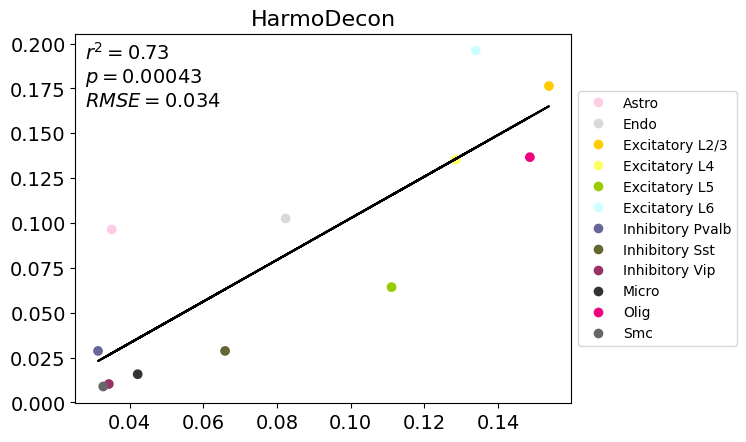

Slope: 1.1605373551804807
Intercept: -0.013378112931706723
Pearson correlation coefficient (r): 0.8522806287544245
p-value: 0.0004299379866620373
r_value: 0.8522806287544245


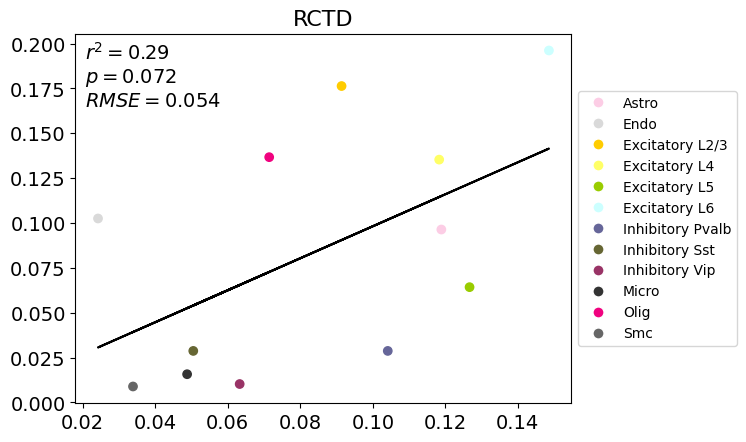

Slope: 0.8914408637735739
Intercept: 0.009046594685535508
Pearson correlation coefficient (r): 0.5370334728804312
p-value: 0.07179155318194907
r_value: 0.5370334728804312


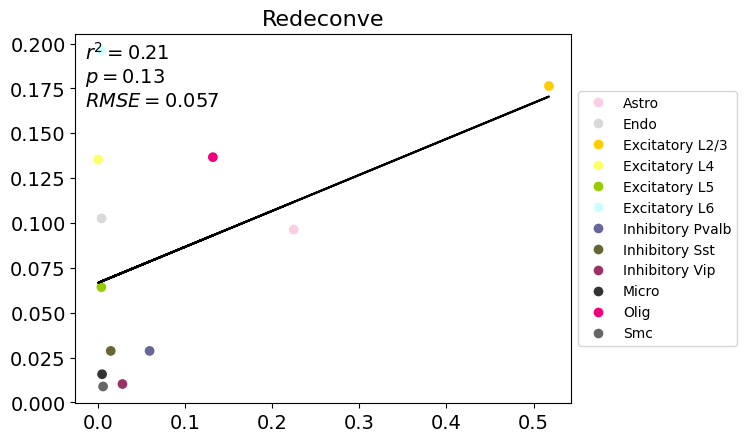

Slope: 0.2006614295808431
Intercept: 0.06661154753492973
Pearson correlation coefficient (r): 0.45856725754524646
p-value: 0.1337723858771738
r_value: 0.45856725754524646


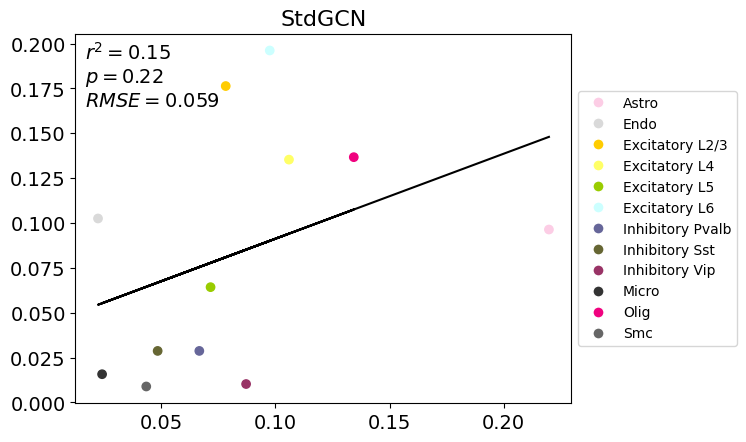

Slope: 0.4741568748900049
Intercept: 0.043820260425832924
Pearson correlation coefficient (r): 0.38449585767820865
p-value: 0.2171753084200179
r_value: 0.38449585767820865


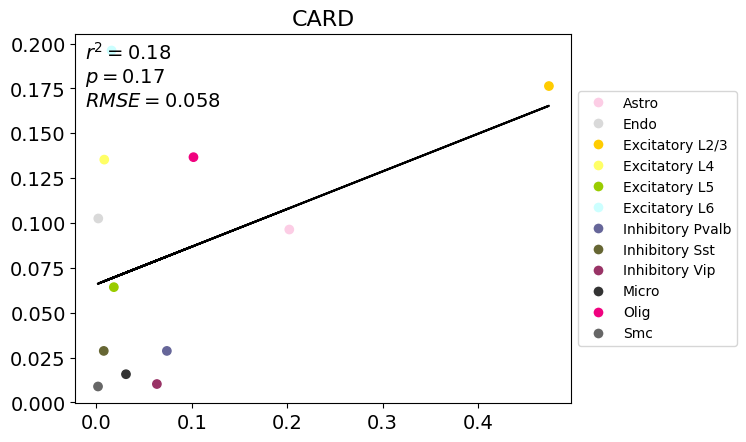

Slope: 0.20971847294079662
Intercept: 0.06585679392160028
Pearson correlation coefficient (r): 0.42686458342467093
p-value: 0.16637932261965332
r_value: 0.42686458342467093


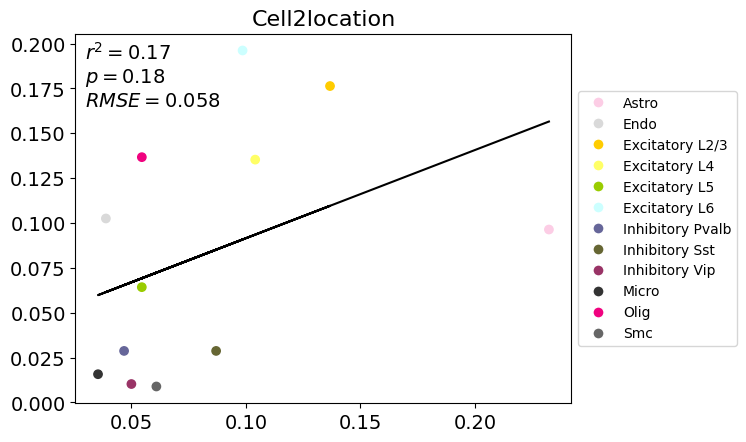

Slope: 0.4917820366044261
Intercept: 0.042351496949631154
Pearson correlation coefficient (r): 0.41187537137942376
p-value: 0.18339584716198148
r_value: 0.41187537137942376


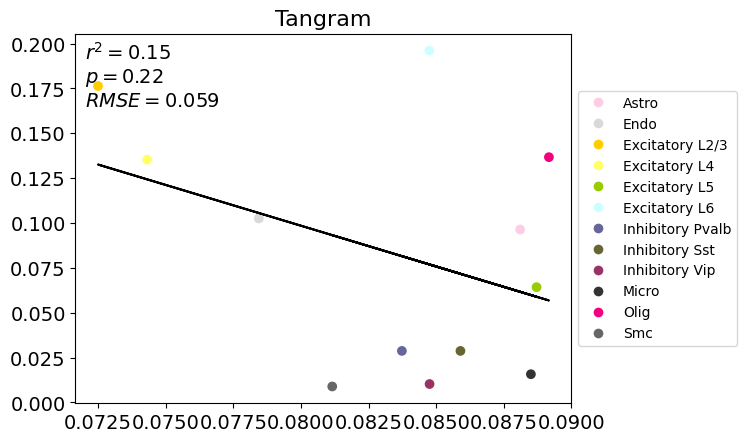

Slope: -4.544264381810758
Intercept: 0.46202203181756313
Pearson correlation coefficient (r): -0.38346970275787756
p-value: 0.218509467691067
r_value: -0.38346970275787756


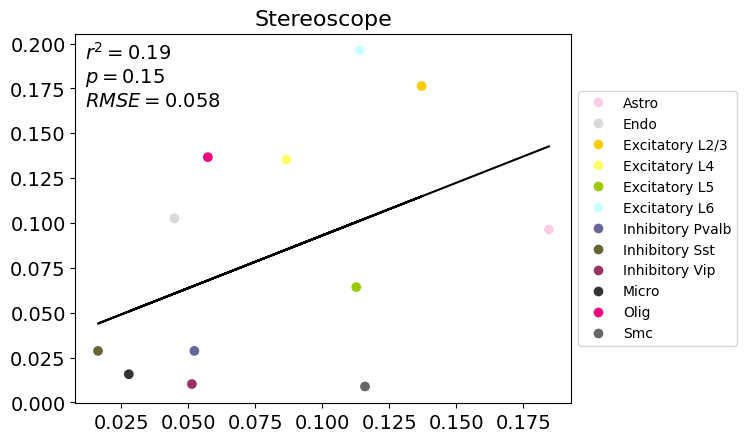

Slope: 0.5868113029117885
Intercept: 0.03443239142401762
Pearson correlation coefficient (r): 0.44035215673738354
p-value: 0.15195031554485605
r_value: 0.44035215673738354


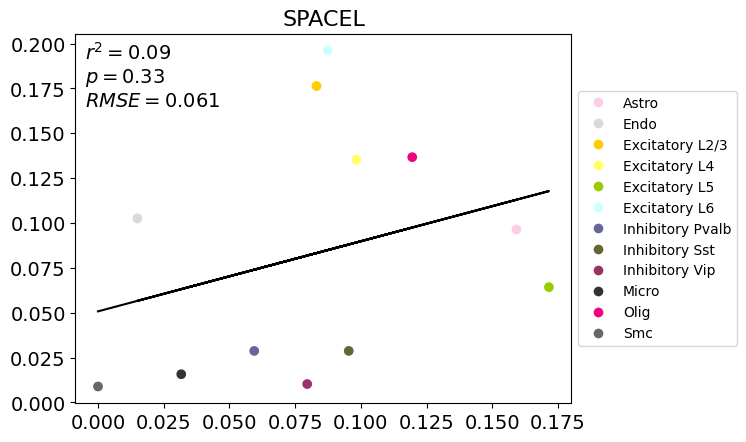

Slope: 0.3909213161849859
Intercept: 0.050756556984584505
Pearson correlation coefficient (r): 0.3055290688461381
p-value: 0.33417598517800884
r_value: 0.3055290688461381


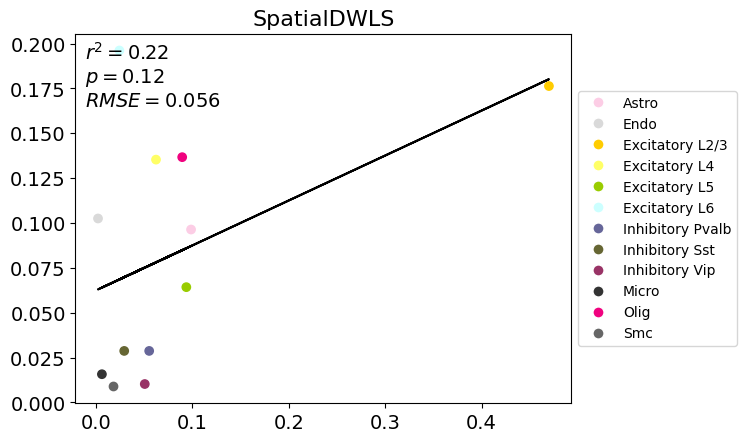

Slope: 0.25053056519811995
Intercept: 0.062455786233490004
Pearson correlation coefficient (r): 0.4725340018981207
p-value: 0.12083492186927704
r_value: 0.4725340018981207


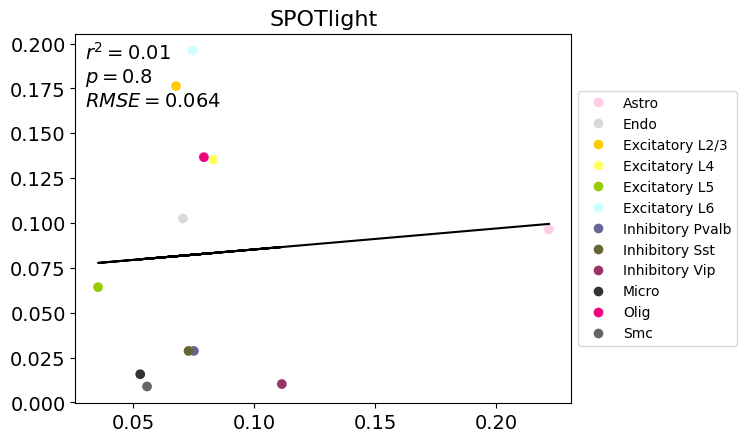

Slope: 0.11679884093678845
Intercept: 0.07360009658860095
Pearson correlation coefficient (r): 0.08259322147232506
p-value: 0.7985806565972889
r_value: 0.08259322147232506


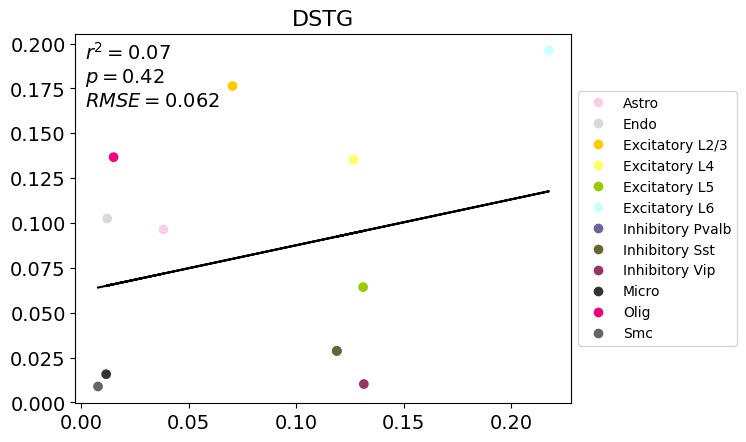

Slope: 0.2558980506453072
Intercept: 0.062008495779557735
Pearson correlation coefficient (r): 0.25725834165543193
p-value: 0.4195452528296636
r_value: 0.25725834165543193


In [58]:
out_dir_linear = output_dir + "/linear"
column = ['HarmoDecon', 'RCTD', 'Redeconve', 'StdGCN','CARD', 'Cell2location', 'Tangram', 'Stereoscope', 'SPACEL', 'SpatialDWLS', 'SPOTlight', 'DSTG']
results_list = [gmgcn_results, RCTD_results, red_results, stdgcn_results, card_results, cell2loc_results,
               tangram_results, stereo_results, spacel_results, spatialdwls_results, spotlight_results, dstg_results]
p_list, r_list, mse_list = plot_linear(out_dir_linear, column, results_list)

/tmp/ipykernel_406680/1927440750.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(labels[::-1], fontsize=20)  # Increase fontsize to 14
/tmp/ipykernel_406680/1927440750.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(labels[::-1], fontsize=20)  # Increase fontsize to 14


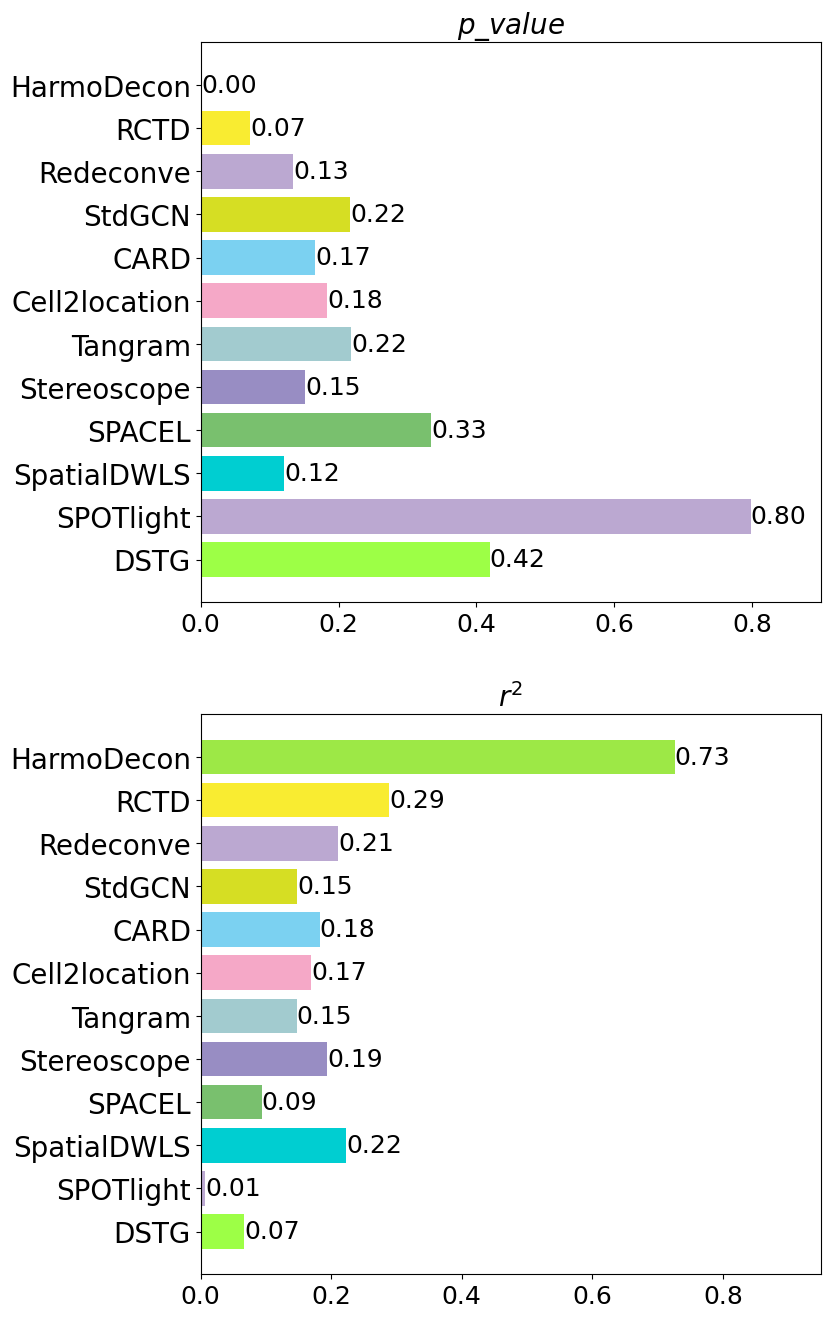

In [59]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 16))

# Given list
colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",  "#A2CBCF", "#988DC3", "#79c06e",'#00CED1',"#BBA8D1", "#9dff46"]
labels = column

# Create a horizontal bar graph with custom colors
bars = axes[0].barh(labels[::-1], p_list[::-1], color=colors[::-1])

# Add values next to each bar
for bar in bars:
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)

axes[0].set_title("$p\_value$", fontsize=20)
axes[0].set_xlim([0, 0.72])
axes[0].set_ylabel('', fontsize=14)  # Remove y-label title

bars_p = axes[1].barh(labels[::-1], r_list[::-1], color=colors[::-1])

# Add values next to each bar
for bar in bars_p:
    width = bar.get_width()
    if width < 0:
        axes[1].text(0, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)
    else:
        axes[1].text(width, bar.get_y() + bar.get_height() / 2, '%.2f' % width, ha='left', va='center', fontsize=18)

axes[0].set_xlim(0, 0.9)
axes[1].set_xlim(0, 0.95)
axes[1].set_title("$r^2$", fontsize=20)
axes[1].set_ylabel('', fontsize=14)  # Remove y-label title

axes[0].set_yticklabels(labels[::-1], fontsize=20)  # Increase fontsize to 14
axes[1].set_yticklabels(labels[::-1], fontsize=20)  # Increase fontsize to 14

for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='x', labelsize=18)

plt.savefig(out_dir_linear + '/barsh.jpg', dpi=300, bbox_inches='tight')
# Display the graph
plt.show()

/tmp/ipykernel_406680/961358191.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(labels[::-1], fontsize=20)  # Increase fontsize to 14


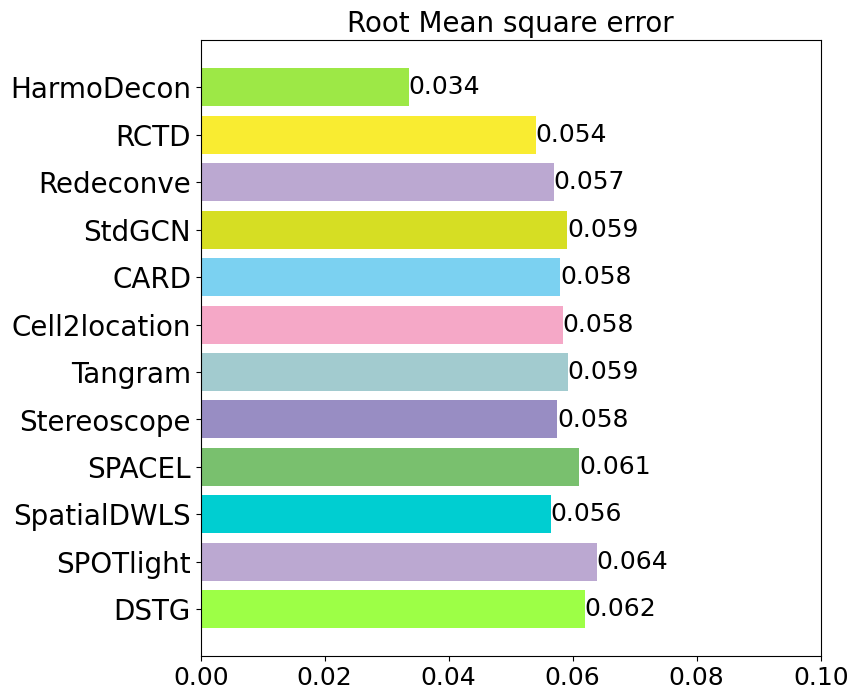

In [60]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))

# Given list
colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",  "#A2CBCF", "#988DC3", "#79c06e",'#00CED1',"#BBA8D1", "#9dff46"]
labels = column

bars = axes.barh(labels[::-1], mse_list[::-1], color=colors[::-1])

# Add values next to each bar
for bar in bars:
    width = bar.get_width()
    axes.text(width, bar.get_y() + bar.get_height() / 2, '%.3f' % width, ha='left', va='center', fontsize=18)

axes.set_xlim(0, 0.1)
axes.set_title("Root Mean square error", fontsize=20)
axes.set_ylabel('', fontsize=14)  # Remove y-label title

axes.set_yticklabels(labels[::-1], fontsize=20)  # Increase fontsize to 14

axes.tick_params(axis='x', labelsize=18)  # Adjust tick parameters for the x-axis

plt.savefig(out_dir_linear + '/mse.jpg', dpi=300, bbox_inches='tight')
# Display the graph
plt.show()

In [61]:
def plot_starmap_celltype(celltype=None,celltype_ind=None,save=None,return_fig=False):
    if celltype is not None:
        celltype_ind = np.where(celltype == tangram_results.columns)[0]
    elif celltype_ind is not None:
        celltype = tangram_results.columns[celltype_ind]
    else:
        raise Error('error')
    print(celltype)
    c_ind = celltype_ind
    fig,axes = plt.subplots(ncols=6,nrows=2,figsize=(25,16.0))
    # fig.tight_layout()
#     axes[0][0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results.iloc[:,c_ind],s=1000,marker='s')
#     axes[0][0].scatter(x=5,y=18,c=0,s=1000,marker='s')
#     axes[0][0].set_xlim(-0.5,9.5)
#     axes[0][0].set_ylim(-0.5,18.5)
#     axes[0][0].axis('off')
#     axes[0][0].set_title('Ground Truth')
    
    axes[0][0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=harmo_results.iloc[:,c_ind],s=1000,marker='s')
    axes[0][0].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[0][0].set_xlim(-0.5,9.5)
    axes[0][0].set_ylim(-0.5,18.5)
    axes[0][0].axis('off')
    axes[0][0].set_title('HarmoDecon', fontsize=24)

    axes[0][1].scatter(x=gd_loc['x'],y=gd_loc['y'],c=RCTD_results.iloc[:,c_ind],s=1000,marker='s')
    axes[0][1].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[0][1].set_xlim(-0.5,9.5)
    axes[0][1].set_ylim(-0.5,18.5)
    axes[0][1].axis('off')
    axes[0][1].set_title('RCTD', fontsize=24)

    axes[0][2].scatter(x=gd_loc['x'],y=gd_loc['y'],c=red_results.iloc[:,c_ind],s=1000,marker='s')
    axes[0][2].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[0][2].set_xlim(-0.5,9.5)
    axes[0][2].set_ylim(-0.5,18.5)
    axes[0][2].axis('off')
    axes[0][2].set_title('Redeconve', fontsize=24)

    axes[0][3].scatter(x=gd_loc['x'],y=gd_loc['y'],c=stdgcn_results.iloc[:,c_ind],s=1000,marker='s')
    axes[0][3].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[0][3].set_xlim(-0.5,9.5)
    axes[0][3].set_ylim(-0.5,18.5)
    axes[0][3].axis('off')
    axes[0][3].set_title('StdGCN', fontsize=24)

    axes[0][4].scatter(x=gd_loc['x'],y=gd_loc['y'],c=stereo_results.iloc[:,c_ind],s=1000,marker='s')
    axes[0][4].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[0][4].set_xlim(-0.5,9.5)
    axes[0][4].set_ylim(-0.5,18.5)
    axes[0][4].axis('off')
    axes[0][4].set_title('Stereoscope', fontsize=24)
    
    axes[0][5].scatter(x=gd_loc['x'],y=gd_loc['y'],c=spacel_results.iloc[:,c_ind],s=1000,marker='s')
    axes[0][5].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[0][5].set_xlim(-0.5,9.5)
    axes[0][5].set_ylim(-0.5,18.5)
    axes[0][5].axis('off')
    axes[0][5].set_title('SPACEL', fontsize=24)
    
    axes[1][0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=cell2loc_results.iloc[:,c_ind],s=1000,marker='s')
    axes[1][0].scatter(x=5,y=18,c=0,s=1000,marker='s')
    axes[1][0].set_xlim(-0.5,9.5)
    axes[1][0].set_ylim(-0.5,18.5)
    axes[1][0].axis('off')
    axes[1][0].set_title('Cell2location', fontsize=24)
    
    axes[1][1].scatter(x=gd_loc['x'],y=gd_loc['y'],c=tangram_results.iloc[:,c_ind],s=1000,marker='s')
    axes[1][1].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[1][1].set_xlim(-0.5,9.5)
    axes[1][1].set_ylim(-0.5,18.5)
    axes[1][1].axis('off')
    axes[1][1].set_title('Tangram', fontsize=24)

    axes[1][2].scatter(x=gd_loc['x'],y=gd_loc['y'],c=spatialdwls_results.iloc[:,c_ind],s=1000,marker='s')
    axes[1][2].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[1][2].set_xlim(-0.5,9.5)
    axes[1][2].set_ylim(-0.5,18.5)
    axes[1][2].axis('off')
    axes[1][2].set_title('SpatialDWLS', fontsize=24)

    axes[1][3].scatter(x=gd_loc['x'],y=gd_loc['y'],c=spotlight_results.iloc[:,c_ind],s=1000,marker='s')
    axes[1][3].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[1][3].set_xlim(-0.5,9.5)
    axes[1][3].set_ylim(-0.5,18.5)
    axes[1][3].axis('off')
    axes[1][3].set_title('Spotlight', fontsize=24)

    axes[1][4].scatter(x=gd_loc['x'],y=gd_loc['y'],c=card_results.iloc[:,c_ind],s=1000,marker='s')
    axes[1][4].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[1][4].set_xlim(-0.5,9.5)
    axes[1][4].set_ylim(-0.5,18.5)
    axes[1][4].axis('off')
    axes[1][4].set_title('CARD', fontsize=24)

    axes[1][5].scatter(x=gd_loc['x'],y=gd_loc['y'],c=dstg_results.iloc[:,c_ind],s=1000,marker='s')
    axes[1][5].scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes[1][5].set_xlim(-0.5,9.5)
    axes[1][5].set_ylim(-0.5,18.5)
    axes[1][5].axis('off')
    axes[1][5].set_title('DSTG', fontsize=24)
    
    
    if save is not None:
        plt.savefig(save,bbox_inches='tight',dpi=300)
    if not return_fig:
        plt.show()
    else:
        plt.close()
        return fig

Excitatory L2/3


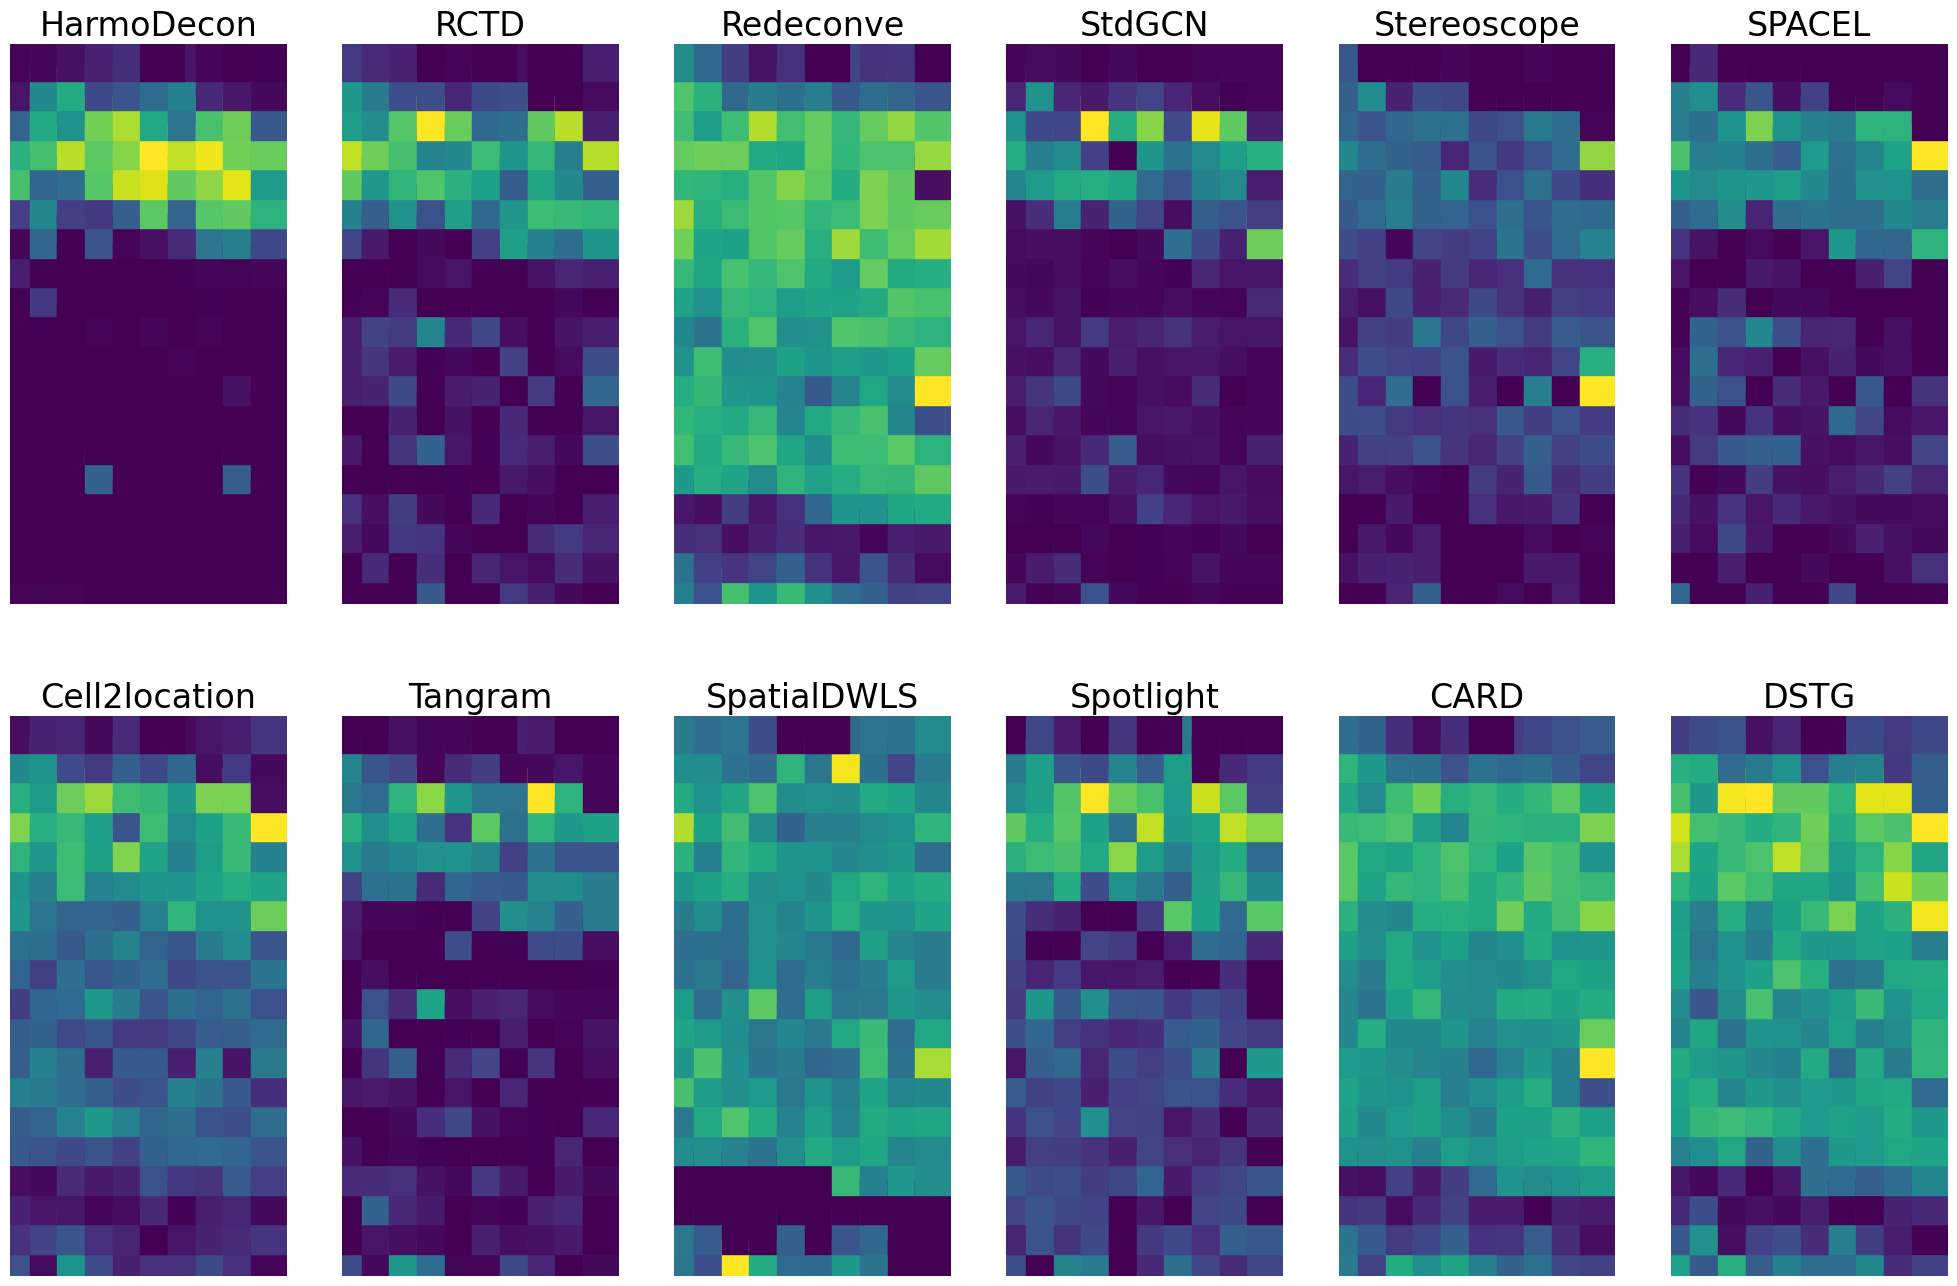

Excitatory L4


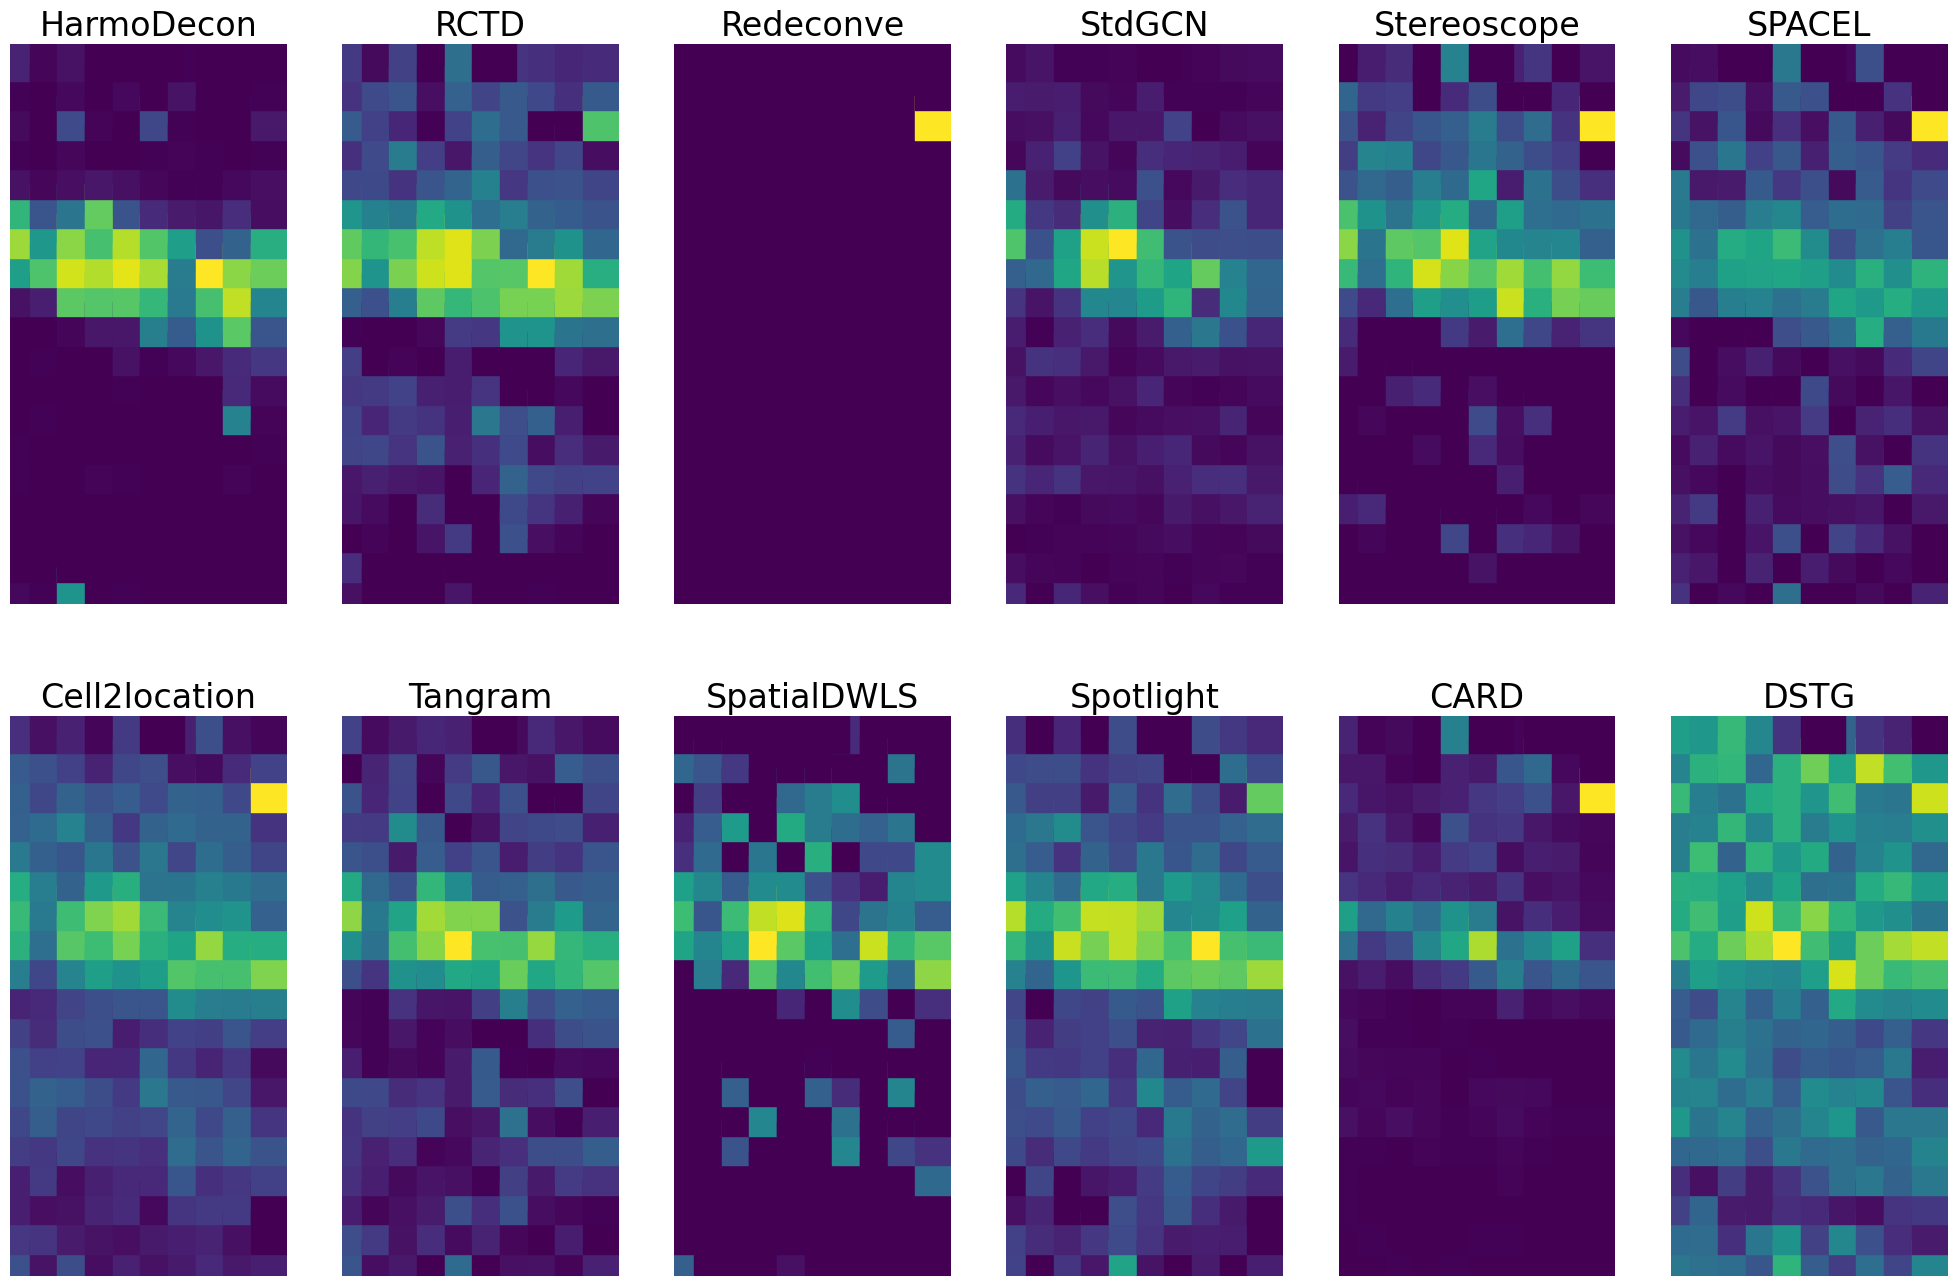

Excitatory L5


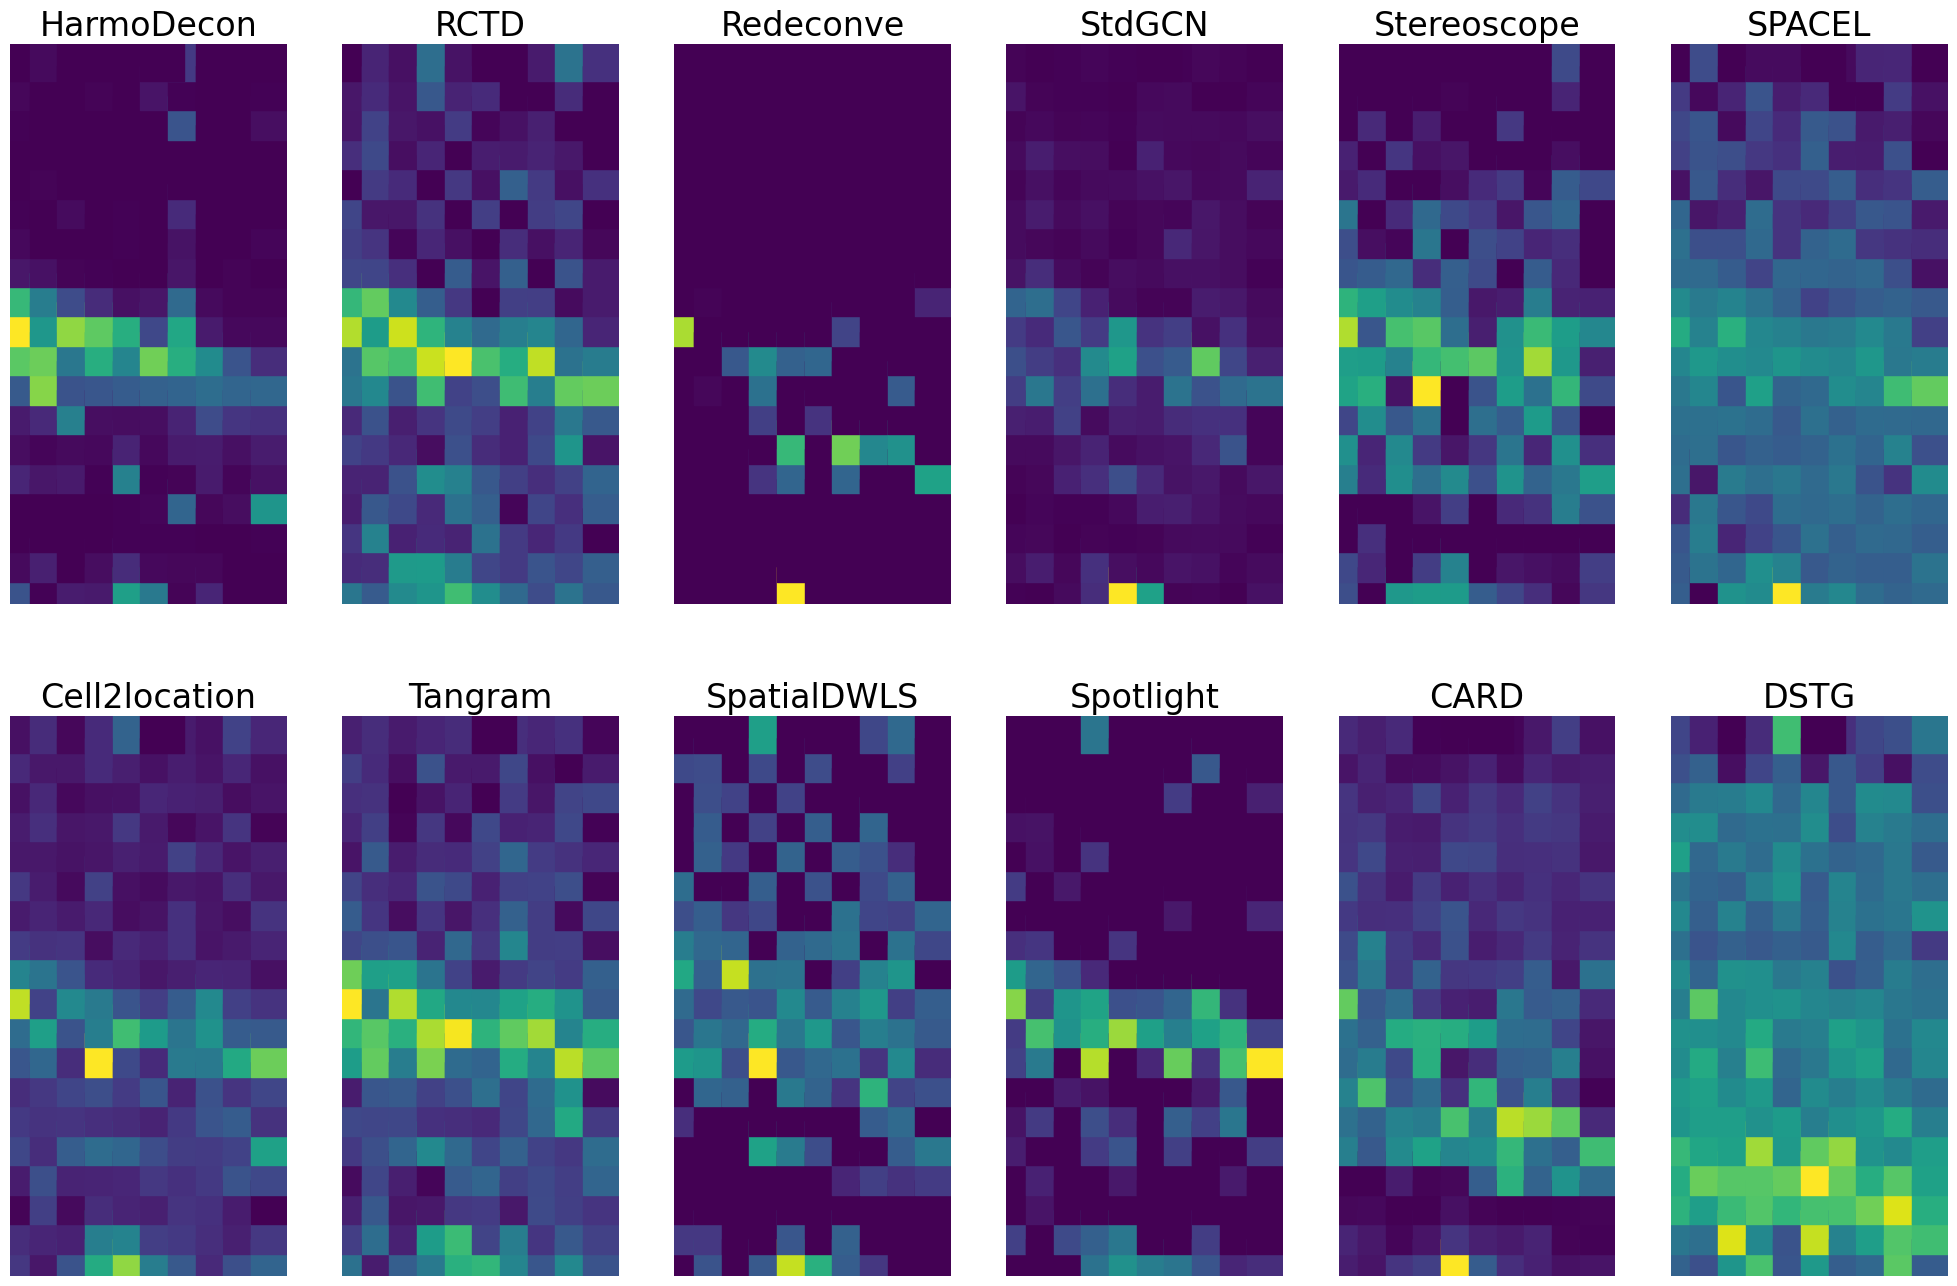

Excitatory L6


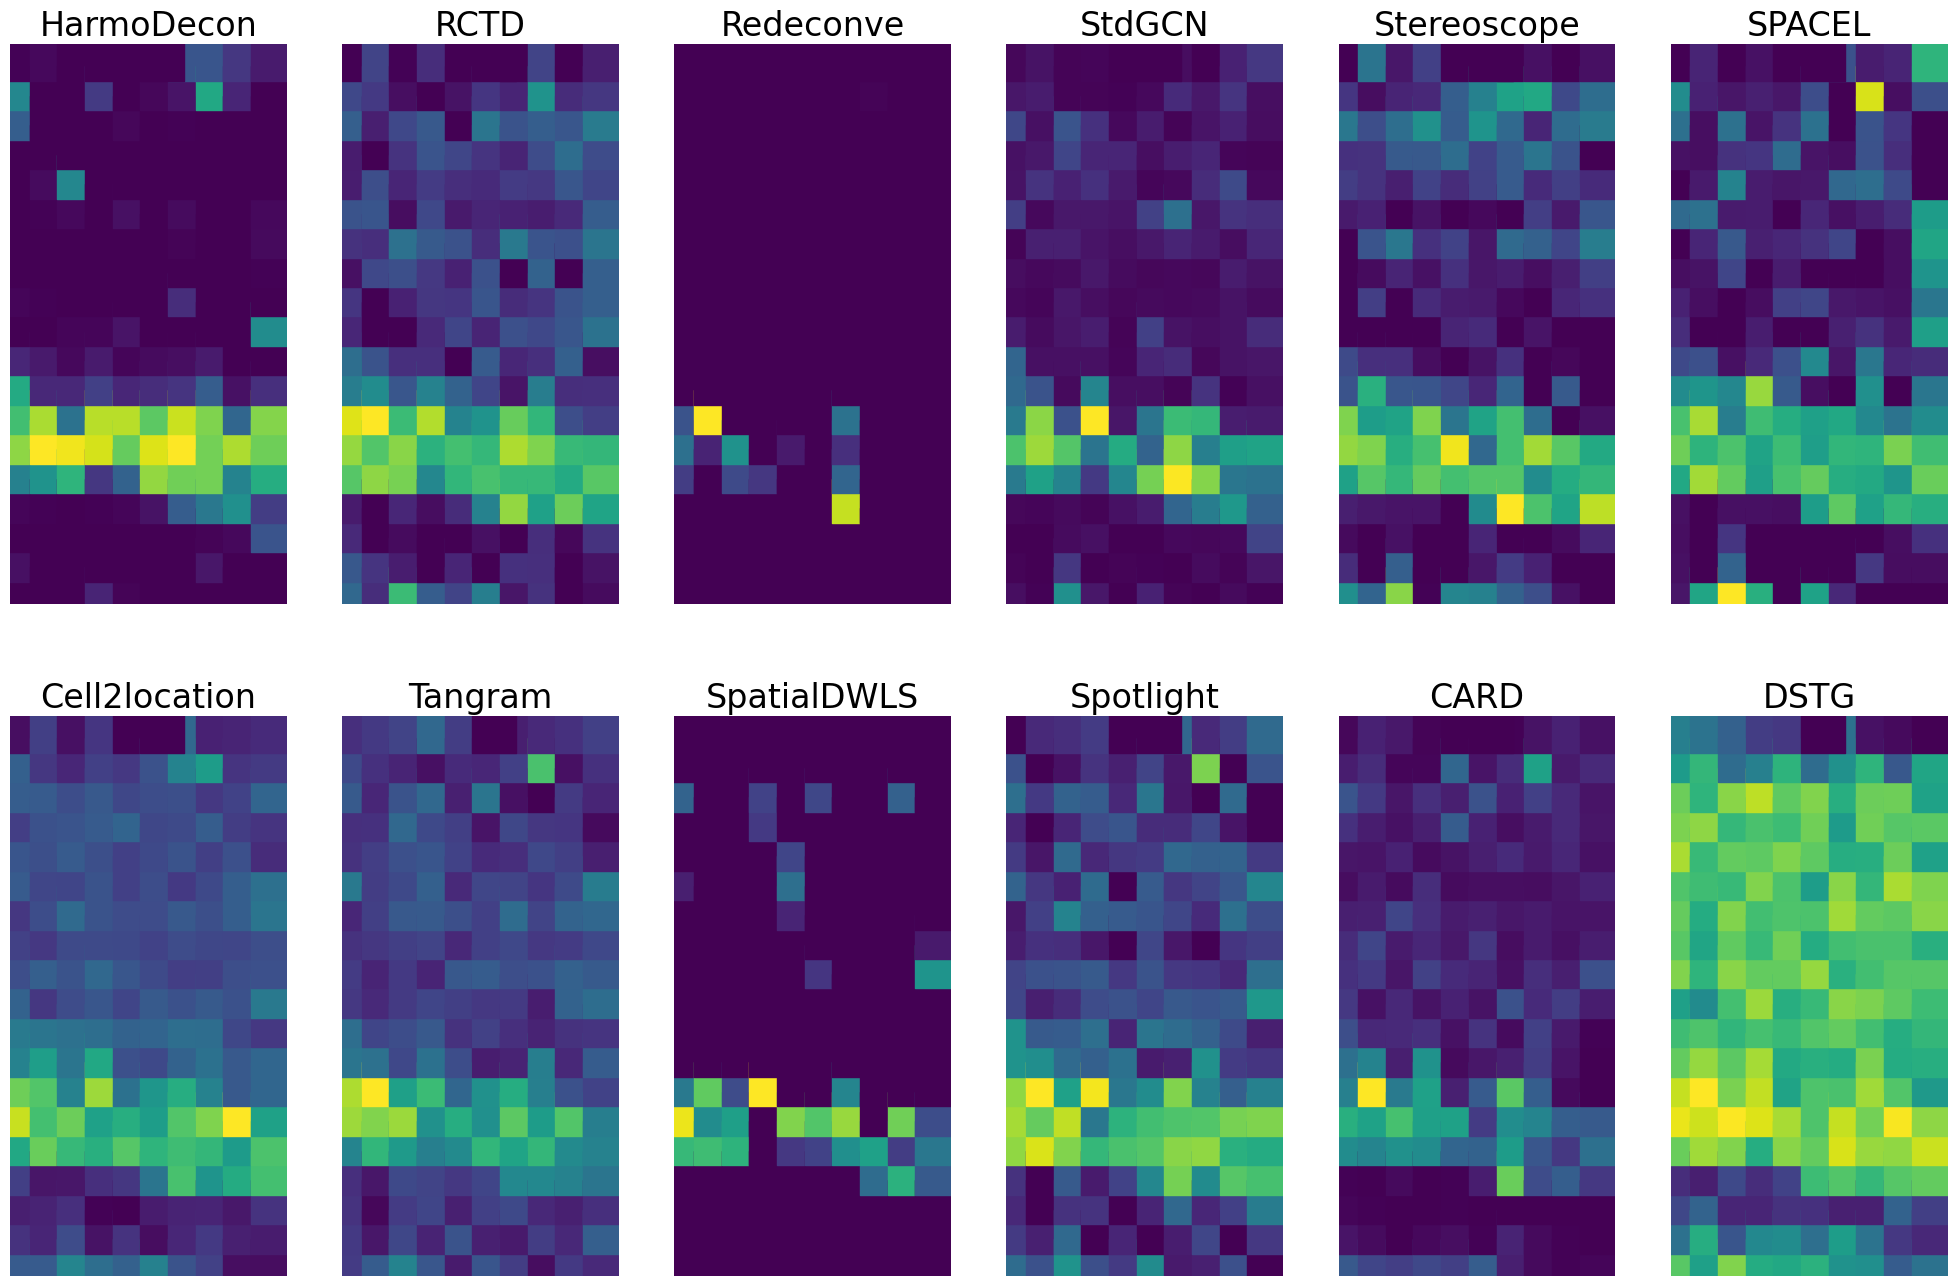

In [62]:
plot_starmap_celltype(celltype_ind=2,save=output_dir + '/starmap_Excitatory_L2_3_methods_red.jpg')
plot_starmap_celltype(celltype_ind=3,save=output_dir + '/starmap_Excitatory_L4_methods_red.jpg')
plot_starmap_celltype(celltype_ind=4,save=output_dir + '/starmap_Excitatory_L5_methods_red.jpg')
plot_starmap_celltype(celltype_ind=5,save=output_dir + '/starmap_Excitatory_L6_methods_red.jpg')

In [64]:
def plot_gd(celltype=None,celltype_ind=None,save=None,return_fig=False):
    if celltype is not None:
        celltype_ind = np.where(celltype == tangram_results.columns)[0]
    elif celltype_ind is not None:
        celltype = tangram_results.columns[celltype_ind]
    else:
        raise Error('error')
    print(celltype)
    c_ind = celltype_ind
    fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(4,8.0))
    # fig.tight_layout()
#     axes[0][0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results.iloc[:,c_ind],s=1000,marker='s')
#     axes[0][0].scatter(x=5,y=18,c=0,s=1000,marker='s')
#     axes[0][0].set_xlim(-0.5,9.5)
#     axes[0][0].set_ylim(-0.5,18.5)
#     axes[0][0].axis('off')
#     axes[0][0].set_title('Ground Truth')
    
    axes.scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results.iloc[:,c_ind],s=1000,marker='s')
    axes.scatter(x=5,y=18,c=0,s=1000,marker='s',)
    axes.set_xlim(-0.5,9.5)
    axes.set_ylim(-0.5,18.5)
    axes.axis('off')
    axes.set_title('Ground Truth', fontsize=24)
    
    
    if save is not None:
        plt.savefig(save,bbox_inches='tight',dpi=300)
    if not return_fig:
        plt.show()
    else:
        plt.close()
        return fig

Excitatory L2/3


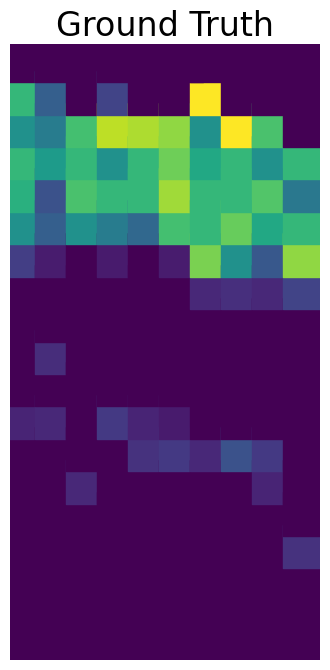

Excitatory L4


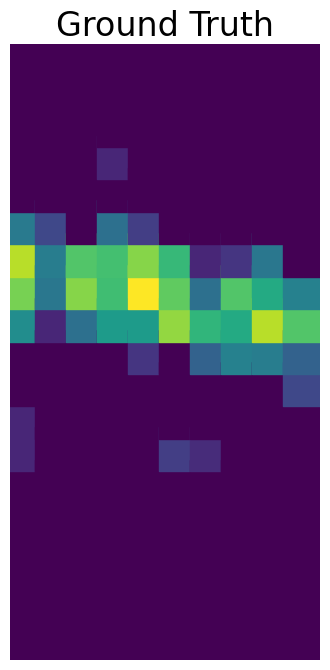

Excitatory L5


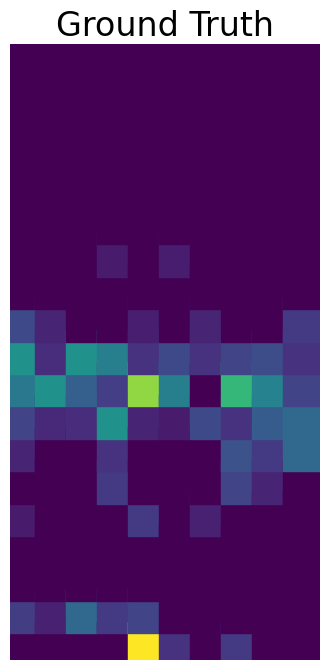

Excitatory L6


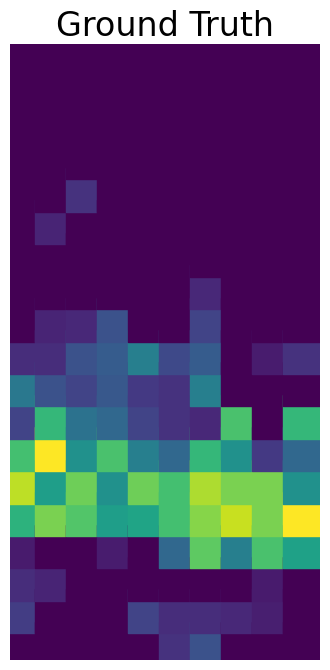

In [65]:
plot_gd(celltype_ind=2,save=output_dir + '/starmap_Excitatory_L2_3_gd.jpg')
plot_gd(celltype_ind=3,save=output_dir + '/starmap_Excitatory_L4_gd.jpg')
plot_gd(celltype_ind=4,save=output_dir + '/starmap_Excitatory_L5_gd.jpg')
plot_gd(celltype_ind=5,save=output_dir + '/starmap_Excitatory_L6_gd.jpg')

In [68]:
def plot_results_bulk_ST_by_spot(coordinates, metadata, dir_out, output_prefix, geometry='honeycomb', num_cols=3):
 
    # Define output files
    fout_png_all = os.path.join(dir_out, f"{output_prefix}cell_type_assignments_by_spot.png")
    fout_pdf_all = os.path.join(dir_out, f"{output_prefix}cell_type_assignments_by_spot.pdf")
    
#     coordinates = coordinates.loc[metadata.index,:]
#     cell_types = list(metadata.columns)[:-1]
    cell_types = list(metadata.columns)
    cell_types = list(np.sort(cell_types))
#     cell_types.insert(0,'Total cells')

    X = coordinates.iloc[:,0]
    Y = coordinates.iloc[:,1]
    
    # distinguish between row/col indices and coordinates
    # based on range (500) and type (int vs. float) of values
    scale = Y.max() < 500 and ((Y - Y.round()).abs() < 1e-5).all()

    # define representative interval between each adjacent spot/point
    y_int = 1 if scale else np.median(np.unique(np.diff(np.sort(np.unique(Y)))))
    x_int = 1 if scale else np.median(np.unique(np.diff(np.sort(np.unique(X)))))
    
    if geometry == 'honeycomb' and scale:
        print('Detecting row and column indexing of Visium data; rescaling for coordinates')
        
        # Rotate
        X_prev = X
        Y_prev = Y
        X = Y_prev
        Y = 1-X_prev
        
        # Rescale
        Y = 1.75*Y

    elif geometry == 'square' and scale:
        print('Detecting row and column indexing of legacy ST data; rotating for coordinates')
        
        # Rotate
        X_prev = X
        Y_prev = Y
        X = Y_prev
        Y = 1-X_prev

    else:        
        # Rotate 
        Y = 1-Y
        
    if geometry == 'honeycomb':
        hex_vert = 6

        if scale:
            hex_rot = 0
            hex_rad = y_int
            hex_rad = hex_rad + 0.2*hex_rad

        else:
            hex_rot = 0
            hex_rad = x_int
            hex_rad = hex_rad + 0.28*hex_rad

    elif geometry == 'square':
        hex_vert = 4
        hex_rot = 45
        interval = y_int
        hex_rad = 0.5*np.sqrt(2*interval**2)

    else:
        print("Unknown geometry specified.")
        exit()

    num_rows = int(len(cell_types)/num_cols)
    if num_rows*num_cols < len(cell_types):
        num_rows = num_rows+1
    width = max(X)-min(X)
    height = max(Y)-min(Y)

#     plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['sans-serif'], 'size':'12'})
    plt.rcParams['figure.dpi'] = 450
    plt.rcParams['savefig.dpi'] = 450

    fig, axes = plt.subplots(num_rows,num_cols,figsize=(width/height*3*num_cols,3*num_rows))
    full_frac = 0.047 * (3*num_rows / (width/height*3*num_cols))
    k = 0
    for i in range(num_rows):
        for j in range(num_cols):

            ax = axes[i,j]

            if k >= len(cell_types):
                ax.axis('off')
            else:
                ct = cell_types[k]
                ax.set_aspect('equal')

                node_assignment = metadata.loc[:,ct]

                viridis = cm.get_cmap('viridis')
                norm = matplotlib.colors.Normalize(min(node_assignment), max(node_assignment))

                node_assignment = (1/max(node_assignment))*node_assignment
                colors = viridis(node_assignment)

                for x, y, c in zip(X, Y, colors):
                    hex = RegularPolygon((x, y), numVertices=hex_vert, radius=hex_rad, 
                                         orientation=np.radians(hex_rot), 
                                         facecolor=c, edgecolor=None)
                    ax.add_patch(hex)

                # Also add scatter points in hexagon centres - not sure why this line has to be here
                ax.scatter(X, Y, c=[c[0] for c in colors],alpha=0)
                ct_label = ct
                # Reformat labels that are too long
                if len(ct_label)>14:
                    ct_label = format_label(ct_label)
                ax.set_title(ct_label)
                cax = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=viridis),ax=ax,label='',fraction=0.036, pad = 0.04)
                
                ticks = cax.get_ticks()
            
                ticks = cax.get_ticks()

                new_ticks = np.linspace(norm.vmin, norm.vmax, len(ticks))

                cax.set_ticks(new_ticks)
                cax.set_ticklabels([f'{tick:.2f}' for tick in new_ticks])

                ax.axis('off')
        
            k += 1

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
#     fig.suptitle('Distribution of Malignmant Cells and Marker Genes')
    plt.show()
    fig.savefig(fout_png_all, facecolor="w", bbox_inches='tight')
    fig.savefig(fout_pdf_all, facecolor="w", bbox_inches='tight')

In [66]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, RegularPolygon
from matplotlib import cm, colors
import matplotlib

import numpy as np
import pandas as pd

import os

In [67]:
def format_label(label,max_length=14,max_lines=3):
    label_words = label.split(' ')
    label_chunks = []
    chunk = ''
    for word in label_words:
        if len(chunk)==0:
            if len(word)>max_length:
                word = word[:max_length]+'...'
                label_chunks.append(word)
            else:
                chunk += word
        elif len(chunk)+len(word)<=(max_length-1):
            chunk = chunk+' '+word
        else:
            label_chunks.append(chunk)
            chunk = word
    if len(chunk)>0:
        label_chunks.append(chunk)
    
    if len(label_chunks)>max_lines:
        label_chunks = label_chunks[:max_lines]
        last_line = label_chunks[-1]
        if len(last_line)>(max_length-3):
            label_chunks[-1] = last_line[:max_length]+'...'
        else: 
            label_chunks[-1] = last_line+'...'

    return '\n'.join(label_chunks)

In [69]:
dir_out = "/home/comp/cszrwang/results/Deconvolution/results/STARmap/"
output_prefix = "harmo"
plot_results_bulk_ST_by_spot(coordinates, harmo_results, dir_out, output_prefix, geometry='square', num_cols=4)

Detecting row and column indexing of legacy ST data; rotating for coordinates


/tmp/ipykernel_406680/1202726877.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


Detecting row and column indexing of legacy ST data; rotating for coordinates


/tmp/ipykernel_406680/1202726877.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


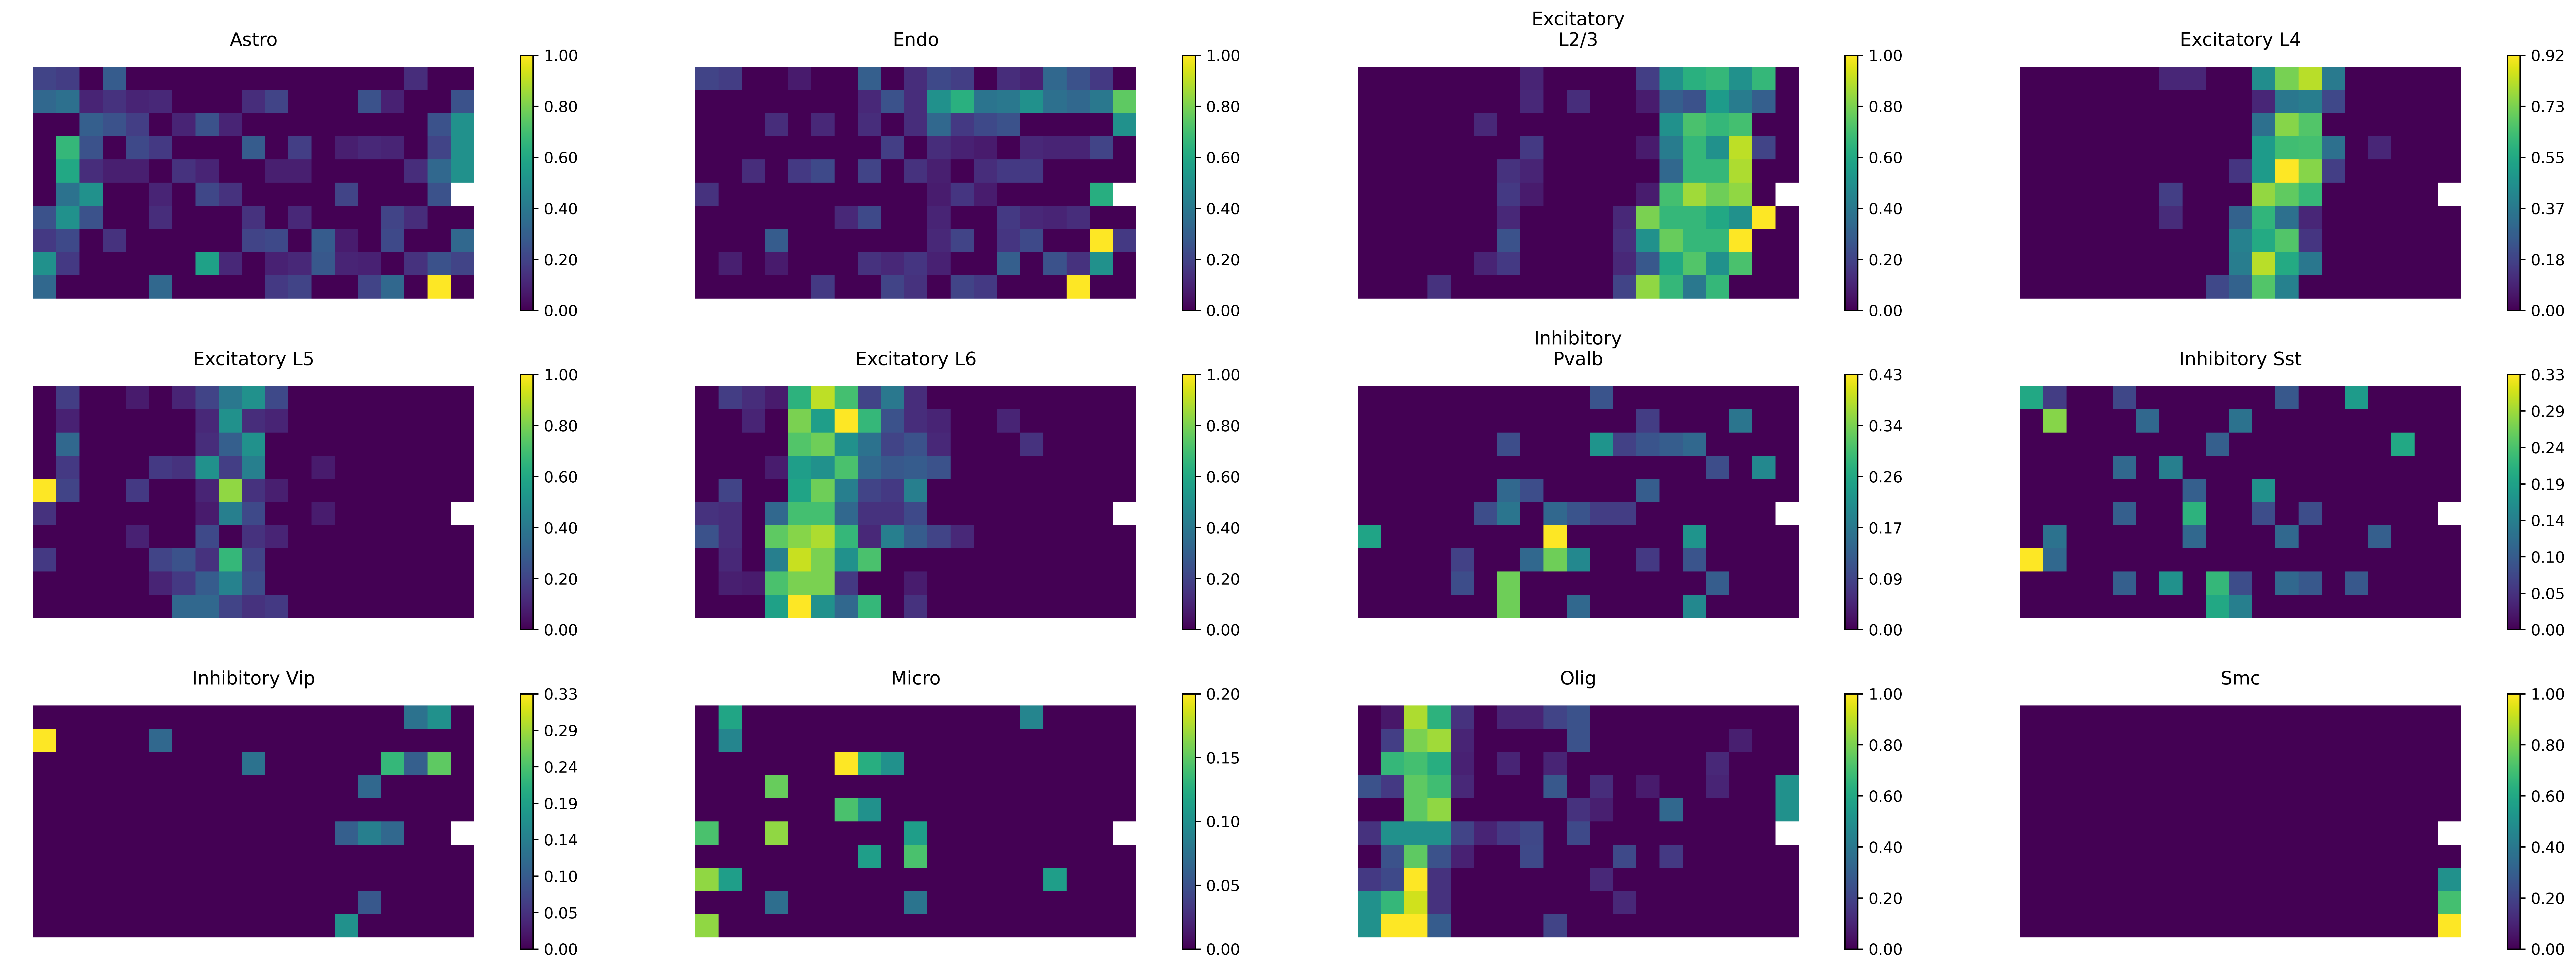

In [70]:
dir_out = "/home/comp/cszrwang/results/Deconvolution/results/STARmap/"
output_prefix = "gd"
plot_results_bulk_ST_by_spot(coordinates, gd_results, dir_out, output_prefix, geometry='square', num_cols=4)